# Описание проекта
Закзачик: Крупная сеть кофеен-пекарен.  
Задача: предсказать, на основании данных, что клиент уйдет в отток.

Описание данных:  
Таблица `data`:  
- clnt_ID - уникальный айди юзера, str   
- timestamp - дата и время совершения покупки, datetime
- gest_Sum - сумма покупки, float
- gest_Discount - сумма скидки, float
 
Таблица `target`
- clnt_ID - уникальный айди юзера, str
- target - флаг оттока, int: 1 если юзер ушел в отток | 0 если НЕ отток

**Небольшая ремарка по поводу того, как проставлялись метки для клиентов**  
Клиент относится к "не-оттоку":
- Если у него только 1 посещение. Мы не хотим предсказывать отток для таких клиентов, так как они еще не являются лояльными (посетившими нас хотя бы 2 раза).
- Если между его посещениями проходило менее 45 дней.
- Если между его последним посещением и датой отсечки прошло менее 45 дней.  

Мы говорим, что клиент ушел в "отток": 
- Если он посещал нас более 1 раза и при этом между его посещениями есть интервал в 45 дней и более.   

В первую очередь, нам будут важны клиенты, которые посетили нас более 1 раза. Для таких клиентов имеет смысл строить прогноз оттока.  

# Импортируем библиотеки и подготовим окружение

In [ ]:
!pip3 install catboost
import pandas as pd
import numpy as np
import datetime
import pickle
import json
import re

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import  GridSearchCV, cross_val_score, cross_val_predict, train_test_split, LeaveOneGroupOut
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_recall_curve, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import calibration_curve, CalibrationDisplay, CalibratedClassifierCV
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier

from catboost import CatBoostClassifier
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

     |████████████████████████████████| 76.6 MB 1.2 MB/s 


Создадим класс `CalibratedClassifierGroupCV` для того, чтобы была возможность передавать группы в `CalibratedClassifierGroup`

In [ ]:
"""
https://gist.github.com/mdbecker/5c236c820faa1b3b324cdb184f18a59e#file-calibration_groups-py
Fixes https://github.com/scikit-learn/scikit-learn/issues/12052
CalibratedClassifierGroupCV is a drop in replacment for CalibratedClassifierCV that supports GroupKFold cv.

This is based off of https://github.com/scikit-learn/scikit-learn/blob/0.24.1/sklearn/calibration.py.
If you are using a different version of sklearn, you can make similar modifications to your version.

Example usage:

```
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
base_clf = RandomForestClassifier()
gfk = GroupKFold(n_splits=5)

calibrated_clf = CalibratedClassifierGroupCV(base_estimator=base_clf, method='isotonic', cv=gfk)
calibrated_clf.fit(X, y, groups=groups)
```

Before you pickle the classifier, you'll also need to monkey patch the class so that it 
can be unpickled without importing `CalibratedClassifierGroupCV`

```
from sklearn.calibration import CalibratedClassifierCV
calibrated_clf.__class__ = CalibratedClassifierCV
pickle.dump(calibrated_clf, file)
```
"""
import warnings
from contextlib import suppress
from functools import partial
from inspect import signature

import numpy as np
from joblib import Parallel

from sklearn.base import clone
from sklearn.calibration import (
    CalibratedClassifierCV, _get_prediction_method, _compute_predictions,
    _fit_calibrator, _fit_classifier_calibrator_pair)
from sklearn.model_selection import check_cv, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.utils import indexable
from sklearn.utils.fixes import delayed
from sklearn.utils.multiclass import check_classification_targets
from sklearn.utils.validation import check_is_fitted, _check_sample_weight


class CalibratedClassifierGroupCV(CalibratedClassifierCV):

    # groups ADDED as a kwarg
    def fit(self, X, y, sample_weight=None, *, groups=None):
        """Fit the calibrated model.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data.
        y : array-like of shape (n_samples,)
            Target values.
        sample_weight : array-like of shape (n_samples,), default=None
            Sample weights. If None, then samples are equally weighted.
        groups : array-like of shape (n_samples,), default=None
            Group labels for the samples used while splitting the dataset into
            train/test set. Only used in conjunction with a "Group" :term:`cv`
            instance (e.g., :class:`~sklearn.model_selection.GroupKFold`).
        Returns
        -------
        self : object
            Returns an instance of self.
        """
        check_classification_targets(y)
        # THIS LINE WAS CHANGED TO ADD groups
        X, y, groups = indexable(X, y, groups)

        if self.base_estimator is None:
            # we want all classifiers that don't expose a random_state
            # to be deterministic (and we don't want to expose this one).
            base_estimator = LinearSVC(random_state=0)
        else:
            base_estimator = self.base_estimator

        self.calibrated_classifiers_ = []
        if self.cv == "prefit":
            # `classes_` and `n_features_in_` should be consistent with that
            # of base_estimator
            if isinstance(self.base_estimator, Pipeline):
                check_is_fitted(self.base_estimator[-1])
            else:
                check_is_fitted(self.base_estimator)
            with suppress(AttributeError):
                self.n_features_in_ = base_estimator.n_features_in_
            self.classes_ = self.base_estimator.classes_

            pred_method = _get_prediction_method(base_estimator)
            n_classes = len(self.classes_)
            predictions = _compute_predictions(pred_method, X, n_classes)

            calibrated_classifier = _fit_calibrator(
                base_estimator, predictions, y, self.classes_, self.method,
                sample_weight
            )
            self.calibrated_classifiers_.append(calibrated_classifier)
        else:
            X, y = self._validate_data(
                X, y, accept_sparse=['csc', 'csr', 'coo'],
                force_all_finite=False, allow_nd=True
            )
            # Set `classes_` using all `y`
            label_encoder_ = LabelEncoder().fit(y)
            self.classes_ = label_encoder_.classes_
            n_classes = len(self.classes_)

            # sample_weight checks
            fit_parameters = signature(base_estimator.fit).parameters
            supports_sw = "sample_weight" in fit_parameters
            if sample_weight is not None:
                sample_weight = _check_sample_weight(sample_weight, X)
                if not supports_sw:
                    estimator_name = type(base_estimator).__name__
                    warnings.warn(f"Since {estimator_name} does not support "
                                  "sample_weights, sample weights will only be"
                                  " used for the calibration itself.")

            # Check that each cross-validation fold can have at least one
            # example per class
            if isinstance(self.cv, int):
                n_folds = self.cv
            elif hasattr(self.cv, "n_splits"):
                n_folds = self.cv.n_splits
            else:
                n_folds = None
            if n_folds and np.any([np.sum(y == class_) < n_folds
                                   for class_ in self.classes_]):
                raise ValueError(f"Requesting {n_folds}-fold "
                                 "cross-validation but provided less than "
                                 f"{n_folds} examples for at least one class.")
            cv = check_cv(self.cv, y, classifier=True)

            if self.ensemble:
                parallel = Parallel(n_jobs=self.n_jobs)

                # groups checks
                split_parameters = signature(cv.split).parameters
                supports_groups = "groups" in split_parameters
                cv_split = partial(cv.split, X=X, y=y)
                if groups is not None:
                    if supports_groups:
                        # ADDED groups
                        cv_split = partial(cv.split, X=X, y=y, groups=groups)
                    else:
                        cv_name = type(cv).__name__
                        warnings.warn(f"{cv_name} does not support groups "
                                      "and will be ignored.")                
                self.calibrated_classifiers_ = parallel(
                    delayed(_fit_classifier_calibrator_pair)(
                        clone(base_estimator), X, y, train=train, test=test,
                        method=self.method, classes=self.classes_,
                        supports_sw=supports_sw, sample_weight=sample_weight)
                    for train, test in cv_split()
                )
            else:
                this_estimator = clone(base_estimator)
                method_name = _get_prediction_method(this_estimator).__name__
                pred_method = partial(
                    cross_val_predict, estimator=this_estimator, X=X, y=y,
                    cv=cv, method=method_name, n_jobs=self.n_jobs
                )
                predictions = _compute_predictions(pred_method, X, n_classes)

                if sample_weight is not None and supports_sw:
                    this_estimator.fit(X, y, sample_weight)
                else:
                    this_estimator.fit(X, y)
                calibrated_classifier = _fit_calibrator(
                    this_estimator, predictions, y, self.classes_, self.method,
                    sample_weight
                )
                self.calibrated_classifiers_.append(calibrated_classifier)

        return self

# 1. Загрузим данные и исследуем их структуру

In [ ]:
# Сохраним путь к файлам 'data' и 'target' в переменные 'data_route' и 'target_route'
data_route = '/content/drive/MyDrive/ds_masterskaya/data.csv'
target_route = '/content/drive/MyDrive/ds_masterskaya/target.csv'

# Созраним данные в переменные 'data' и 'target'
data = pd.read_csv(data_route)
target = pd.read_csv(target_route)

## 1.1 Изучим таблицу `data`

In [ ]:
# Посмотрим на первые 5 строк таблицы data
data.head()

,clnt_ID,timestamp,gest_Sum,gest_Discount
0,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-02 09:09:17.060,900.000000,300.0
1,8DA65A37-C1D0-41D4-98E1-AB6C5BF1367F,2021-01-02 09:12:24.850,165.000000,55.0
2,26ACF3C8-25C8-4345-ABC2-33DA15EA6454,2021-01-02 09:38:21.643,800.500000,25.5
3,0F77DDB3-A9A7-44BE-AAAB-9DF59B66A695,2021-01-02 09:45:17.793,580.000000,0.0
4,F16BCF77-FA5A-4093-B7E3-FA86E2B1EA31,2021-01-02 09:59:50.453,148.899994,3.1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2371635 entries, 0 to 2371634
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   clnt_ID        object 
 1   timestamp      object 
 2   gest_Sum       float64
 3   gest_Discount  float64
dtypes: float64(2), object(2)
memory usage: 72.4+ MB


In [ ]:
print('Количество уникальных клиентов в таблице data =', data['clnt_ID'].nunique())

Количество уникальных клиентов в таблице data = 255109


In [ ]:
print(f'Количество пропусков в data = {data.isna().sum().sum()}')
print(f'Количество дубликатов в data = {data.duplicated().sum()}')

Количество пропусков в data = 0
Количество дубликатов в data = 129


In [ ]:
# Выведем на экран дублирующиеся строки
data[data.duplicated(keep=False)]

,clnt_ID,timestamp,gest_Sum,gest_Discount
639,1FA367BD-8E07-437E-AB6A-009D53533128,2021-01-02 12:00:00.000,982.200012,0.000000
663,1FA367BD-8E07-437E-AB6A-009D53533128,2021-01-02 12:00:00.000,982.200012,0.000000
85786,3319362D-F6AD-498B-9B53-F59D0418915E,2021-01-14 14:00:00.000,1189.000000,0.000000
85787,3319362D-F6AD-498B-9B53-F59D0418915E,2021-01-14 14:00:00.000,1189.000000,0.000000
133279,A145C6F8-EDCB-47B1-BF5D-B328F6AF97CA,2021-01-20 16:00:00.000,0.000000,0.000000
...,...,...,...,...
2165277,E99EFF35-01BE-49A9-8F61-641F752051E5,2021-11-08 15:00:00.000,0.000000,0.000000
2174627,1A4C0239-A7AB-4188-84DB-8F52FBF6E13C,2021-11-10 11:00:00.000,282.239990,37.759998
2174629,1A4C0239-A7AB-4188-84DB-8F52FBF6E13C,2021-11-10 11:00:00.000,282.239990,37.759998
2198034,C9D86AF9-373C-4531-92A4-8FC752DD5D75,2021-11-14 12:00:00.000,0.000000,0.000000


In [ ]:
data[data.duplicated(keep=False)].timestamp.unique()

array(['2021-01-02 12:00:00.000', '2021-01-14 14:00:00.000',
       '2021-01-20 16:00:00.000', '2021-01-21 12:00:00.000',
       '2021-01-21 14:00:00.000', '2021-01-27 12:00:00.000',
       '2021-01-31 11:30:00.000', '2021-02-12 18:00:00.000',
       '2021-02-14 14:00:00.000', '2021-02-20 11:00:00.000',
       '2021-02-20 13:45:00.000', '2021-02-22 16:00:00.000',
       '2021-02-23 12:00:00.000', '2021-02-23 14:00:00.000',
       '2021-02-23 16:00:00.000', '2021-02-24 12:00:00.000',
       '2021-02-26 22:00:00.000', '2021-03-02 15:00:00.000',
       '2021-03-04 10:00:00.000', '2021-03-05 12:00:00.000',
       '2021-03-05 14:00:00.000', '2021-03-08 11:00:00.000',
       '2021-03-08 18:00:00.000', '2021-03-08 21:00:00.000',
       '2021-03-09 12:00:00.000', '2021-03-09 18:00:00.000',
       '2021-03-10 12:00:00.000', '2021-03-11 13:00:00.000',
       '2021-03-12 12:00:00.000', '2021-03-16 12:00:00.000',
       '2021-03-17 11:00:00.000', '2021-03-19 12:00:00.000',
       '2021-03-19 13:00

**Краткое резюме по таблице `data`**  
- Количество уникальных клиентов в таблице data = 255109
- Отсутствуют пропуски 
- Присутствует 129 дубликатов. Вероятнее всего мы удалим повторяющиеся значения, так как это похоже на ошибку. Причем во всех дубликатах в строке timestamp время покупки асолютно округленное число.

## 1.2 Изучим таблицу `target`

In [ ]:
# Посмотрим на первые 5 строк таблицы target
target.head()

,clnt_ID,target
0,000070A8-DB9E-4AB7-8C4D-6169D4AEBB2A,1
1,00007EB0-6331-438E-A917-E9840C260876,0
2,0000993D-A30E-4233-AB3F-D368D9A0D2C4,1
3,0000A724-7BC5-408F-9F16-6CC3AB16322F,0
4,0000B90C-56DE-43C2-A213-624AFBE36DB2,0


In [ ]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255109 entries, 0 to 255108
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   clnt_ID  255109 non-null  object
 1   target   255109 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.9+ MB


In [ ]:
print(f'Количество дубликатов в target = {target.duplicated().sum()}')

Количество дубликатов в target = 0


Убедимся, что каждому уникальному клиенту присвоена лишь одна метка.

In [ ]:
target.groupby('clnt_ID')['target'].count()[lambda x: x != 1]

Series([], Name: target, dtype: int64)

Да, все именно так.

**Краткое резюме по таблице `target`**  
- Всего в таблице 255109 клиентов (совпадает с количеством уникальных клиентов в таблице `data`)
- Пропуски отсутствуют
- Дубликаты отсутствуют
- Каждому клиенту присвоена одна метка

# 2. Предобработка данных

Для того, чтобы провести исследовательский анализ нам необходимо создать новые признаки.  
Покупки, визиты:  
- Общее количество покупок за год
- Общее количество визитов за год
- Среднее количество визитов в месяц
- Среднее количество визитов в неделю
- Среднее количество покупок в день
- Среднее количество дней между визитами  

Чек покупки:
- Общая сумма трат за период (год) 
- Средний чек за 1-у транзакцию
- Средние траты в день
- Средние траты в неделю
- Средние траты в месяц
- Средний размер скидки в расчете на 1-у покупку
- Доля покупок со скидкой в общем количестве покупок  

Первым делом удалим дубликаты.  
Затем создадим в исходной таблице `data` новые столбцы, на основе имеющихся данных.

In [ ]:
# Удалим дубликаты
data = data.drop_duplicates()
# Присоеденим target
data = data.merge(target, on='clnt_ID')
# Преобразуем столбец 'timestamp' в формат "datetime"
data['timestamp'] = pd.to_datetime(data['timestamp']) 
# Процент скидки в долях
data['discount'] =  data['gest_Discount'] / (data['gest_Sum'] + data['gest_Discount']) 
# Заполним пропуски в столбце discount на 1. Так как пропуски у нас будут стоять в тех местах, где клиент совершил беслпатную покупку. Это означает, что скидка была равна 1.
data['discount'] = data['discount'].fillna(1)
# Извлечем календарную дату (с 2021-01-01 оп 2021-12-31)
data['date'] = data['timestamp'].dt.date 
# Извлечем номер месяца (с 1 по 12 месяц)
data['month'] = data['timestamp'].dt.month 
# Извлечем номер недели (Неделя начинается с Понедельника)
data['num_of_week'] = data['timestamp'].dt.strftime('%W').astype('int')
# Извлечем день недели (0 - Воскресенье, 6 - Суббота) 
data['day_of_week'] = data['timestamp'].dt.strftime('%w').astype('int') 
# Извлечем час покупки (от 0 до 23)
data['hour'] = data['timestamp'].dt.hour
# Создадим булевой столбец "день = рабочий"
data['is_working_day'] = (data['day_of_week'] < 5).astype('int')
# Срздадим булевой столбец "день = выходной"
data['is_weekend'] = (data['day_of_week'] > 4).astype('int')
# Срздадим булевой столбец "покупка совершена в промежуток с 6 до 9.59 часов"
data['is_day_part_1'] = (data['hour'] <= 9).astype('int') 
# Срздадим булевой столбец "покупка совершена в промежуток с 10 до 14.59 часов"
data['is_day_part_2'] = data['hour'].between(10, 14).astype('int')
# Срздадим булевой столбец "покупка совершена в промежуток с 15 до 18.59 часов"
data['is_day_part_3'] = data['hour'].between(15, 18).astype('int')
# Срздадим булевой столбец "покупка совершена в промежуток с 19 до 23.59 часов"
data['is_day_part_4'] = data['hour'].between(19, 23).astype('int')

# Вспомогательный столюец. Индикатор того, что покупка была совершена. Столбец заполнен единицами для всех строк.
data['purchase_stamp'] = 1 
# Вспомогательный столбец. Индикатор того, что покупка была совершена со скидкой.
data['disc_purchase_stamp'] = (data['discount'] > 0).astype('int') 

In [ ]:
data.isna().sum()

clnt_ID                0
timestamp              0
gest_Sum               0
gest_Discount          0
target                 0
discount               0
date                   0
month                  0
num_of_week            0
day_of_week            0
hour                   0
is_working_day         0
is_weekend             0
is_day_part_1          0
is_day_part_2          0
is_day_part_3          0
is_day_part_4          0
purchase_stamp         0
disc_purchase_stamp    0
dtype: int64

Создадим несколько вспомогательных функций.

In [ ]:
# Функция, которая принимает список отсортированных уникальныз дат посещения, и возвращает список с интервалами между посещениями
def list_all_deltas(sorted_dates):
  sorted_dates = list(sorted_dates)
  deltas = []
  # Если клиент посетил пекарню лишь раз, то интервалов нет - возвращаем Nan
  if len(sorted_dates) == 1:
    return np.nan
  # Если посещений 2 и более - возвращаем список с интервалами между посещениями
  else:
    for i in range(1, len(sorted_dates)):
      delta = sorted_dates[i] - sorted_dates[i-1]
      delta = delta.days - 1
      deltas.append(delta)
    return deltas

# Функция, которая считает средний интервал между посещениями клиента
def count_mean_delta(sorted_dates):
  deltas = list_all_deltas(sorted_dates)
  # Если посещений 2 и более - возвращаем средний интервал между посещениями
  try:
    mean_delta = sum(deltas) / len(deltas)
    return mean_delta
  # Если клиент посетил пекарню лишь раз, то интервалов нет - возвращаем Nan
  except:
    return np.nan

Рассчитаем необходимые метрики.  
Группируем по клиентам и считаем средние метрики за весь период (год). Количество объектов в таблице = количеству клиентов.

In [ ]:
# Общее количество покупок за год
total_num_of_purchases = data.groupby(['clnt_ID'])['timestamp'].count() 
# Общее количество визитов за год
total_num_of_visits_per_year = data.groupby(['clnt_ID'])['date'].nunique() 
# Среднее количество визитов в месяц
avg_num_of_visits_per_month = data.groupby(['clnt_ID', 'month'])['date'].nunique().groupby('clnt_ID').mean()
 # Среднее количество визитов в неделю
avg_num_of_visits_per_week = data.groupby(['clnt_ID', 'num_of_week'])['date'].nunique().groupby('clnt_ID').mean()
# Среднее количество покупок в день
avg_num_of_purch_per_day = data.groupby(['clnt_ID', 'date'])['purchase_stamp'].sum().groupby('clnt_ID').mean()
# Среденее количество дней между визитами
avg_days_btw_visits = data.groupby('clnt_ID')['date'].unique().apply(count_mean_delta) 
# Общая сумма трат за период (год)
total_spend_per_year = data.groupby('clnt_ID')['gest_Sum'].sum() 
# Средние траты в месяц
avg_spend_per_month = data.groupby(['clnt_ID', 'month'])['gest_Sum'].sum().groupby('clnt_ID').mean()
# Средние траты в неделю 
avg_spend_per_week = data.groupby(['clnt_ID', 'num_of_week'])['gest_Sum'].sum().groupby('clnt_ID').mean()
# Средние траты в день
avg_spend_per_day = data.groupby(['clnt_ID', 'date'])['gest_Sum'].sum().groupby('clnt_ID').mean()
# Средний чек за 1-у транзакцию
avg_bill_per_transaction = data.groupby('clnt_ID')['gest_Sum'].mean()
# Средний размер скидки в расчете на 1-у покупку
avg_discount_per_purchase = data.groupby(['clnt_ID'])['discount'].mean() 
# Доля покупок со скидкой в общем количестве покупок
purch_with_discount_ratio = data.groupby('clnt_ID')[['purchase_stamp', 'disc_purchase_stamp']].sum().apply(lambda row: row[1] / row[0], axis=1) 

# Создадим словарь "data_dict", в который передадим объекты Series с новыми признаками и их названия
data_dict = {'total_num_of_purchases': total_num_of_purchases, 
              'total_num_of_visits_per_year': total_num_of_visits_per_year,
              'avg_num_of_visits_per_month': avg_num_of_visits_per_month,
              'avg_num_of_visits_per_week': avg_num_of_visits_per_week,
              'avg_num_of_purch_per_day': avg_num_of_purch_per_day,
              'avg_days_btw_visits': avg_days_btw_visits,
              'total_spend_per_year': total_spend_per_year,
              'avg_spend_per_month': avg_spend_per_month,
              'avg_spend_per_week': avg_spend_per_week,
              'avg_spend_per_day': avg_spend_per_day,
              'avg_bill_per_transaction': avg_bill_per_transaction,
              'avg_discount_per_purchase': avg_discount_per_purchase,
              'purch_with_discount_ratio': purch_with_discount_ratio
             }

# На основе словаря "data_dict" создадим объект DataFrame "data_new" и присоеденим таблицу "target" с целевой переменной.
data_new = pd.DataFrame(data_dict).merge(target, on='clnt_ID')

In [ ]:
data_new.head()

,clnt_ID,total_num_of_purchases,total_num_of_visits_per_year,avg_num_of_visits_per_month,avg_num_of_visits_per_week,avg_num_of_purch_per_day,avg_days_btw_visits,total_spend_per_year,avg_spend_per_month,avg_spend_per_week,avg_spend_per_day,avg_bill_per_transaction,avg_discount_per_purchase,purch_with_discount_ratio,target
0,000070A8-DB9E-4AB7-8C4D-6169D4AEBB2A,3,2,1.000000,1.000000,1.500000,27.00000,1575.600037,787.800018,787.800018,787.800018,525.200012,0.037774,1.0,1
1,00007EB0-6331-438E-A917-E9840C260876,1,1,1.000000,1.000000,1.000000,NaN,214.000000,214.000000,214.000000,214.000000,214.000000,0.027273,1.0,0
2,0000993D-A30E-4233-AB3F-D368D9A0D2C4,1,1,1.000000,1.000000,1.000000,NaN,470.000000,470.000000,470.000000,470.000000,470.000000,0.000000,0.0,1
3,0000A724-7BC5-408F-9F16-6CC3AB16322F,64,58,5.272727,1.870968,1.103448,4.45614,17550.599976,1595.509089,566.148386,302.596551,274.228125,0.106645,1.0,0
4,0000B90C-56DE-43C2-A213-624AFBE36DB2,1,1,1.000000,1.000000,1.000000,NaN,549.000000,549.000000,549.000000,549.000000,549.000000,0.000000,0.0,0


Также создадим функцию, которая будет создавать признаки и объединять их в одну таблицу, на которой мы будем проводить обучение и анализ.  
**Стратегия:**  
- Сгруппируем данные по каждому месяцу.  
- Внутри каждого месяца сгруппируем по клиентам.  
- Для каждого клиента рассчитаем его фактические метрики за месяц.
- Сконкатенируем данные за все месяцы.


In [ ]:
def transform_raw_data_for_ml(df_raw, target_df, drop_clnt_id=False, first_month=1, last_month=10, month_ind=False, fill_na=None):
  # Создадим пустую таблицу с наименованиями признаков.
  data_concatanated = pd.DataFrame({'num_of_visits_per_month': [],
                                    'avg_num_of_visits_per_week': [],
                                    'avg_num_of_purch_per_day': [],
                                    'spend_per_month': [],
                                    'avg_spend_per_week': [],
                                    'avg_spend_per_day': [],
                                    'avg_bill_per_transaction': [],
                                    'avg_discount_per_purchase': [],
                                    'purch_with_discount_ratio': [],
                                    'avg_days_btw_visits': [],
                                    'avg_bill_std': [],
                                    'days_till_end_of_month': [], 
                                    'avg_days_btw_visits_std': [], 
                                    'median_hour': [], 
                                    'mean_hour_std': [], 
                                    'median_day_of_week': [], 
                                    'mean_day_of_week_std': [],
                                    'is_working_day_ratio': [],
                                    'is_weekend_ratio': [],
                                    'is_day_part_1_ratio': [],
                                    'is_day_part_2_ratio': [],
                                    'is_day_part_3_ratio': [],
                                    'is_day_part_4_ratio': []
              }
  )
  # Для каждого месяца с января по октябрь: возмем данные за месяц -> вычислим значения признаков
  for month in range(first_month, last_month + 1):
    # Берем срез за 1 месяц
    df = df_raw[df_raw['month'] == month]

    # Вычисляем признаки:
    # Абсолютное количество визитов за месяц
    num_of_visits_per_month =  df.groupby(['clnt_ID'])['date'].nunique() 
    # Среднее количество визитов в неделю
    avg_num_of_visits_per_week = df.groupby(['clnt_ID', 'num_of_week'])['date'].nunique().groupby('clnt_ID').mean()
    # Среднее количество покупок в день
    avg_num_of_purch_per_day = df.groupby(['clnt_ID', 'date'])['purchase_stamp'].sum().groupby('clnt_ID').mean()
    # Общая сумма трат за период (месяц)
    spend_per_month = df.groupby('clnt_ID')['gest_Sum'].sum() 
    # Средние траты в неделю
    avg_spend_per_week = df.groupby(['clnt_ID', 'num_of_week'])['gest_Sum'].sum().groupby('clnt_ID').mean()
    # Средние траты в день
    avg_spend_per_day = df.groupby(['clnt_ID', 'date'])['gest_Sum'].sum().groupby('clnt_ID').mean()
    # Средний чек за 1-у транзакцию
    avg_bill_per_transaction = df.groupby('clnt_ID')['gest_Sum'].mean() 
    # Средний размер скидки в расчете на 1-у покупку
    avg_discount_per_purchase = df.groupby(['clnt_ID'])['discount'].mean()
    # Доля покупок со скидкой в общем количестве покупок
    purch_with_discount_ratio = df.groupby('clnt_ID')[['purchase_stamp', 'disc_purchase_stamp']].sum().apply(lambda row: row[1] / row[0], axis=1)

    # Среденее количество дней между визитами (для тех, у кого был лишь 1 визит - заменим nan на "0") (МОЖЕТ СОДЕРЖАТЬ NAN)
    avg_days_btw_visits = df.groupby('clnt_ID')['date'].unique().apply(count_mean_delta).fillna(fill_na if not isinstance(fill_na, type(None)) else np.nan)
    # Стандартное отклонение чека (для тех, у кого был лишь 1 чек - заменим nan на "0") (МОЖЕТ СОДЕРЖАТЬ NAN)
    avg_bill_std = df.groupby('clnt_ID')['gest_Sum'].std().fillna(fill_na if not isinstance(fill_na, type(None)) else np.nan) 
    # Количество дней между последним визитом концом месяца, нормированное на 31 (так, словно мы смотрим на клиентов 1-го числа нового месяца)
    days_till_end_of_month = df.groupby('clnt_ID')['date'].unique().apply(np.max).apply(lambda x: (31 - x.day) / 31)
    # Стандартное отклонение от среднего интервала между визитами (насколько гость стабилен в своих интервалах) (МОЖЕТ СОДЕРЖАТЬ NAN)
    avg_days_btw_visits_std = df.groupby('clnt_ID')['date'].unique().apply(list_all_deltas).apply(lambda x: np.std(x)).fillna(fill_na if not isinstance(fill_na, type(None)) else np.nan)
    # Медианный час, когда гость приходит в кафе
    median_hour = df.groupby('clnt_ID')['hour'].median()
    # Стандартное отклонение от среднего часа, когда гость приходит в кафе (насколько гость постоянен в отношении времени посещения) (МОЖЕТ СОДЕРЖАТЬ NAN)
    mean_hour_std = df.groupby('clnt_ID')['hour'].std().fillna(fill_na if not isinstance(fill_na, type(None)) else np.nan)
    # Медианный день недели, когда гость приходит в кафе
    median_day_of_week = df.groupby('clnt_ID')['day_of_week'].median()
    # Стандартное отклонение от среднего дня недели, когда гость приходит в кафе (насколько гость постоянен в отношении дня посещения) (МОЖЕТ СОДЕРЖАТЬ NAN)
    mean_day_of_week_std = df.groupby('clnt_ID')['day_of_week'].std().fillna(fill_na if not isinstance(fill_na, type(None)) else np.nan)

    # Доля посещений в рабочие дни
    is_working_day_ratio = df.groupby('clnt_ID')['is_working_day'].apply(lambda x: x.sum() / x.count())
    # Доля посещений в выходные дни
    is_weekend_ratio = df.groupby('clnt_ID')['is_weekend'].apply(lambda x: x.sum() / x.count())
    # Доля посещений в 1-й четверти дня
    is_day_part_1_ratio = df.groupby('clnt_ID')['is_day_part_1'].apply(lambda x: x.sum() / x.count())
    # Доля посещений во 2-ой четверти дня
    is_day_part_2_ratio = df.groupby('clnt_ID')['is_day_part_2'].apply(lambda x: x.sum() / x.count())
    # Доля посещений в 3-ей четверти дня
    is_day_part_3_ratio = df.groupby('clnt_ID')['is_day_part_3'].apply(lambda x: x.sum() / x.count())
    # Доля посещений в 4-й четверти дня
    is_day_part_4_ratio = df.groupby('clnt_ID')['is_day_part_4'].apply(lambda x: x.sum() / x.count())

    data_dict = {'num_of_visits_per_month': num_of_visits_per_month,
                 'avg_num_of_visits_per_week': avg_num_of_visits_per_week,
                 'avg_num_of_purch_per_day': avg_num_of_purch_per_day,
                 'spend_per_month': spend_per_month,
                 'avg_spend_per_week': avg_spend_per_week,
                 'avg_spend_per_day': avg_spend_per_day,
                 'avg_bill_per_transaction': avg_bill_per_transaction,
                 'avg_discount_per_purchase': avg_discount_per_purchase,
                 'purch_with_discount_ratio': purch_with_discount_ratio,
                 'avg_days_btw_visits': avg_days_btw_visits,
                 'avg_bill_std': avg_bill_std,
                 'days_till_end_of_month': days_till_end_of_month, 
                 'avg_days_btw_visits_std': avg_days_btw_visits_std, 
                 'median_hour': median_hour, 
                 'mean_hour_std': mean_hour_std, 
                 'median_day_of_week': median_day_of_week, 
                 'mean_day_of_week_std': mean_day_of_week_std,
                 'is_working_day_ratio': is_working_day_ratio,
                 'is_weekend_ratio': is_weekend_ratio,
                 'is_day_part_1_ratio': is_day_part_1_ratio,
                 'is_day_part_2_ratio': is_day_part_2_ratio,
                 'is_day_part_3_ratio': is_day_part_3_ratio,
                 'is_day_part_4_ratio': is_day_part_4_ratio
              }

    # На основе словаря "data_dict" создадим объект DataFrame "df_one_month", который содержит информацию о поведении пользователя за месяц
    df_one_month = pd.DataFrame(data_dict)

    if month_ind:
      df_one_month['month_ind'] = month
    # Присоединяем данные о поведении пользователей за новый месяц снизу к таблице
    data_concatanated = pd.concat([data_concatanated, df_one_month])

  # Присоеденим таблицу "target" с целевой переменной.
  data_concatanated = data_concatanated.merge(target_df, left_index=True, right_on='clnt_ID')
  data_concatanated = data_concatanated.reset_index(drop=True)
  
  # Удалим столбец 'clnt_ID', если drop_clnt_id=True
  if drop_clnt_id:
    data_for_ml = data_concatanated.drop('clnt_ID', axis=1)
    return data_for_ml
  # В противном случае вернем таблицу с индексами клиентов
  else:
    return data_concatanated

Данная функция возвращает нам таблицу `data_cocatanated`:
- с признаками и с ID клиентов (если `drop_clnt_id` == False)  

Или таблицу `data_for_ml`:
- с признаками и без ID клиентов (если `drop_clnt_id` == True)  

Сохраним неободимые датасеты для более быстрого доступа к ним.

In [ ]:
# data_for_eda = transform_raw_data_for_ml(data, target, first_month=1, last_month=12, month_ind=True)
# data_for_eda.to_csv('/content/drive/MyDrive/ds_masterskaya/data_for_eda.csv')
data_for_eda = pd.read_csv('/content/drive/MyDrive/ds_masterskaya/data_for_eda.csv', index_col=0)

In [ ]:
data_for_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 690973 entries, 0 to 690972
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   num_of_visits_per_month     690973 non-null  float64
 1   avg_num_of_visits_per_week  690973 non-null  float64
 2   avg_num_of_purch_per_day    690973 non-null  float64
 3   spend_per_month             690973 non-null  float64
 4   avg_spend_per_week          690973 non-null  float64
 5   avg_spend_per_day           690973 non-null  float64
 6   avg_bill_per_transaction    690973 non-null  float64
 7   avg_discount_per_purchase   690973 non-null  float64
 8   purch_with_discount_ratio   690973 non-null  float64
 9   avg_days_btw_visits         400453 non-null  float64
 10  avg_bill_std                419414 non-null  float64
 11  days_till_end_of_month      690973 non-null  float64
 12  avg_days_btw_visits_std     400453 non-null  float64
 13  median_hour   

Также, сохраним ID "не-отточных" клиентов посетивших нас лишь раз в переменную `non_churn_visited_once_IDs`

In [ ]:
non_churn_visited_once_IDs = data_new[(data_new['total_num_of_visits_per_year'] == 1) & (data_new['target'] == 0)]['clnt_ID']

Сохраним строки, в которых содержатся посещения клиентов с интервалом между последним и предпоследним визитом 45 дней и более в переменную `churned_last_visit_IDs`.  
Дело в том, что все визиты, которые случились через 45 и более дней должны были быть удалены. Для того, чтобы избежать утечки данных, мы удалим данные визиты в далнейшем на этапе обучения моделей машинного обучения.

In [ ]:
days_diff = data[data['target'] == 1].groupby('clnt_ID')['date'].diff()
churned_last_visit_rows_ind = days_diff.dropna()[days_diff.dropna().apply(lambda x: x.days - 1) >= 45].index

### Краткое резюме

На данном этапе мы создали признаки, которыми можно описать клиентов.

1. `data_new`  

Содержит признаковое описание для каждого клиента, а также вектор целевых отметок. Данные сгруппированы по клиентам. Агрегация за весь период (год). Количество строк в таблице `data_new` совпадает с количеством уникальных клиентов.  
Содержит столбцы:

Покупки, визиты:  
- Общее количество покупок за год `total_num_of_purchases`
- Общее количество визитов за год `total_num_of_visits_per_year`
- Среднее количество визитов в месяц `avg_num_of_visits_per_month`
- Среднее количество визитов в неделю `avg_num_of_visits_per_week`
- Среднее количество покупок в день `avg_num_of_purch_per_day`
- Среднее количество дней между визитами `avg_days_btw_visits`  

Чек покупки:
- Общая сумма трат за период (год) `total_spend_per_year`
- Средние траты в месяц `avg_spend_per_month`
- Средние траты в неделю `avg_spend_per_week`
- Средние траты в день `avg_spend_per_day`
- Средний чек за 1-у транзакцию `avg_bill_per_transaction`
- Средний размер скидки в расчете на 1-у покупку `avg_discount_per_purchase`
- Доля покупок со скидкой в общем количестве покупок `purch_with_discount_ratio`     
  
  
2. `data_for_eda`  

Содержит данные, сгруппированные по "месяцу -> внутри месяца по ID клиента".   

Содержит столбцы:
- Абсолютное количество визитов за месяц `num_of_visits_per_month`
- Среднее количество визитов в неделю `avg_num_of_visits_per_week` 
- Среднее количество покупок в день `avg_num_of_purch_per_day`
- Общая сумма трат за период (месяц) `spend_per_month`
- Средние траты в неделю `avg_spend_per_week`
- Средние траты в день `avg_spend_per_day`
- Средний чек за 1-у транзакцию `avg_bill_per_transaction`
- Средний размер скидки в расчете на 1-у покупку `avg_discount_per_purchase`
- Доля покупок со скидкой в общем количестве покупок
`purch_with_discount_ratio`  
  
   
- Среденее количество дней между визитами (для тех, у кого был лишь 1 визит - заменим nan на "0") (может содержать пропуски) `avg_days_btw_visits`
- Стандартное отклонение чека (для тех, у кого был лишь 1 чек - заменим nan на "0") (может содержать пропуски) `avg_bill_std`
-  Количество дней между последним визитом концом месяца, нормированное на 31 (так, словно мы смотрим на клиентов 1-го числа нового месяца) `days_till_end_of_month`
- Стандартное отклонение от среднего интервала между визитами (насколько гость стабилен в своих интервалах) (может содержать пропуски) `avg_days_btw_visits_std`
- Медианный час, когда гость приходит в кафе `median_hour`
- Стандартное отклонение от среднего часа, когда гость приходит в кафе (насколько гость постоянен в отношении времени посещения) (может содержать пропуски) `mean_hour_std` 
- Медианный день недели, когда гость приходит в кафе `median_day_of_week`
- Стандартное отклонение от среднего дня недели, когда гость приходит в кафе (насколько гость постоянен в отношении дня посещения) (может содержать пропуски) `mean_day_of_week_std`  
  
  
- Доля посещений в рабочие дни `is_working_day_ratio `
- Доля посещений в выходные дни `is_weekend_ratio` 
- Доля посещений в 1-й четверти дня `is_day_part_1_ratio`
- Доля посещений во 2-ой четверти дня `is_day_part_2_ratio`
- Доля посещений в 3-ей четверти дня `is_day_part_3_ratio`
- Доля посещений в 4-й четверти дня `is_day_part_3_ratio`





# 3. Исследовательский анализ данных

На данном этапе исследуем разницу в значениях раличных признаков в 2-х группах клиентов: группе оттока (класс 1) и группе НЕ оттока (класс 0).  
Далее, клиентов класса 0 для простоты будем называть "не-отток", клиентов класса 1 - "ушедшими", либо "отток".

Посмотрим на соотношение классов.

In [ ]:
target.target.value_counts()

0    128857
1    126252
Name: target, dtype: int64

Классов практически поровну.

In [ ]:
mask_0 = data_new['target'] == 0
mask_1 = data_new['target'] == 1

In [ ]:
# Создадим функцию, которая будет отрисовывать 2 графика: по клиентам из оттока и из не-оттока
def compare_2_groups_plot(feature_name, suptitle, df=data_new, mask_0=mask_0, mask_1=mask_1):
  fig, ax = plt.subplots(2, 2, figsize=(10, 4), constrained_layout=True)
  fig.suptitle(suptitle, fontsize=15)

  ax[0, 0].hist(df[mask_0][feature_name], bins=100);
  ax[0, 0].set_title("target = 0 (loyal)");
  ax[0, 0].grid()

  ax[0, 1].hist(df[mask_1][feature_name], bins=100);
  ax[0, 1].set_title("target = 1 (churned)");
  ax[0, 1].grid()

  ax[1, 0].boxplot(df.dropna()[mask_0][feature_name], vert=False);
  ax[1, 0].grid()

  ax[1, 1].boxplot(df.dropna()[mask_1][feature_name], vert=False);
  ax[1, 1].grid()

  plt.show()

  display(df.pivot_table(columns='target', values=feature_name, aggfunc=['mean', 'median', 'min', 'max']))

  return fig, ax

### 3.1 Есть ли различия в общем количестве покупок за год (`total_num_of_purchases`)?

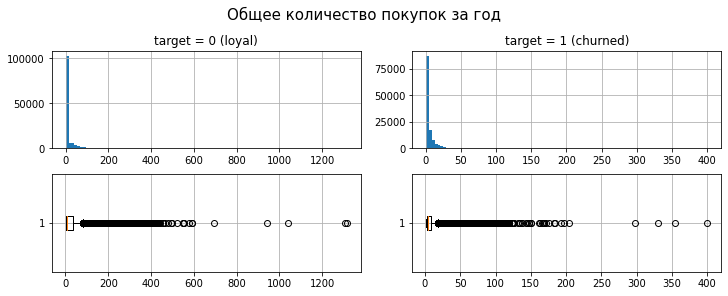

mean           median    min      max     
target                          0         1      0  1   0  1     0    1
total_num_of_purchases  13.190599  5.321143      2  2   1  1  1314  400

In [ ]:
compare_2_groups_plot('total_num_of_purchases', 'Общее количество покупок за год');

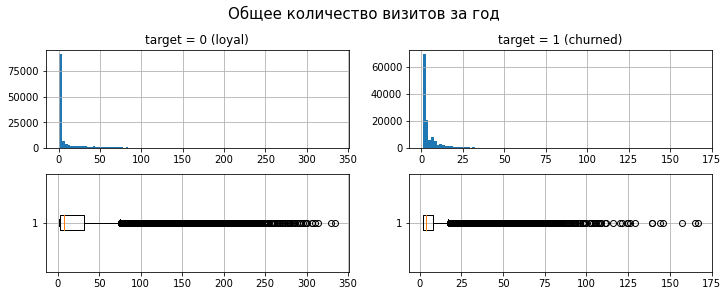

mean          median    min     max     
target                                0        1      0  1   0  1    0    1
total_num_of_visits_per_year  11.681445  4.87296      1  2   1  1  334  167

In [ ]:
compare_2_groups_plot('total_num_of_visits_per_year', 'Общее количество визитов за год');

В среднем клиенты "не-отток" посетили кафе примерно в три раза больше нежели клиенты ушедшие. (То же касается и количества покупок)  
Максимальное количество посещений у "не-отток" клиентов в 2 раза больше нежели у клиентов ушедших. Максимлаьное количество посещений у ушедших клиентов - 167. Получается, некоторое время данный клиент все же был лояльным, но в какой-то момент он стал посещать кафе реже, чем раз в 45 дней либо же вовсе ушел.  
Если допустить предположение, что есть некая модель поведения, по которой мы можем распознать потенциально уходящего клиента, то тогда, может быть 2 варианта:  
- Либо клиент всегда "вел себя" как потенциально уходящий клиент, но по какой-то причине посещал заведение -> тогда на основании аггрегированных данных о его поведении за год мы сможем его распознать
- Либо же в первые месяцы он вел себя как клиент лояльный (соответсвенно в первые месяцы его визитов мы бы присвоили ему метку 0), но в какой-то определенный момент он стал "вести себя" как клиент склонный к уходу - и ушел, тогда в тот момент, когда он изменил свое поведение мы должны присвоить ему метку 1 -> тогда нам необходимо анализировать поведение клиентов в динамике и выдавать прогноз на ближайшие 45 дней, тем самым отвечать на вопрос: при текущем поведении/признаках склонен ли клиент совершить покупку в ближайшие 45 дней?

Также, если посмотреть на медиану, то окажется, что "не-отток"-клиенты в среднем посетили кафе 1 раз за год, в то время как клиенты ушедшие - 2 раза. 
Так могло получиться потому, что гостям посетившим заведение лишь 1 раз проставлялись метка "не-отток".  

Интересно, как изменится статистика по посещениям, если мы уберем клиентов с 1-м посещением, отнесенных к классу 0.

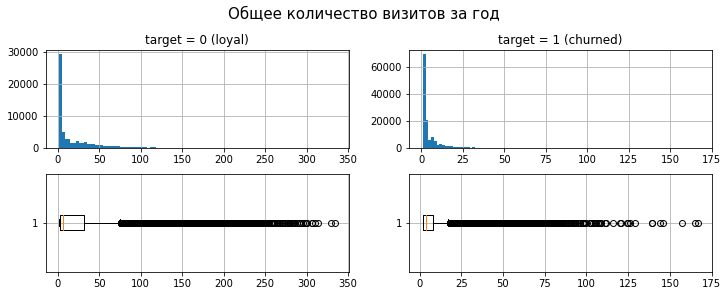

mean          median    min     max     
target                                0        1      0  1   0  1    0    1
total_num_of_visits_per_year  22.495846  4.87296      7  2   2  1  334  167

In [ ]:
compare_2_groups_plot('total_num_of_visits_per_year', 'Общее количество визитов за год',
                      df=data_new[((data_new['target'] == 0) & (data_new['total_num_of_visits_per_year'] > 1)) | ((data_new['target'] == 1))],
                      mask_0=mask_0, 
                      mask_1=mask_1
                      );

Теперь хорошо видно, что клиенты из "не-оттока", посетившие пекарню в среднем 22 раза, а по медиане - 7 раз.  
В тоже время, клиенты из оттока в среднем посетили кофейню 4 раза, а по медиане - 2 раза.

Следющим шагом, построим сводную таблицу, чтобы посмотреть количество клиентов каждого класса по месяцам.

В сводной таблице ниже мы:
- Группируем данные по месяцам
- Внутри каждого месяца считаем количество (уникальных) клиентов, которые были отнесены к группе "не-отток" и "ушедшие"

В данном случае, один и тот же клиент может встречать повторно в разные месяцы.

In [ ]:
# Количество уникальных клиентов в каждом месяце каждой группы, посетивших пекарню
print('Количество уникальных клиентов в каждом месяце каждой группы, посетивших пекарню')

unique_clients_each_month = (
    (
        data.groupby('month')
        .apply(lambda df: df.drop_duplicates(subset='clnt_ID'))
        .pipe(lambda df: df.reset_index(drop=True))
        .groupby(['month', 'target'])['clnt_ID']
        .count()
        )
    .reset_index()
    .pivot_table(index='month', columns='target')
    )
 
unique_clients_each_month = unique_clients_each_month.join(pd.Series(unique_clients_each_month.apply(lambda row: row[0] / (row[0] + row[1]), axis = 1), 
                  name='share_of_loyal'))
unique_clients_each_month

Количество уникальных клиентов в каждом месяце каждой группы, посетивших пекарню


,"(clnt_ID, 0)","(clnt_ID, 1)",share_of_loyal
month,,,
1,27449,53752,0.338038
2,29859,52983,0.360433
3,33713,50100,0.402241
4,32601,41518,0.439847
5,33640,33453,0.501394
6,32835,22725,0.590983
7,32844,14797,0.689406
8,35375,9848,0.782235
9,37226,6206,0.857110


В сводной таблице ниже мы:
- Оставляем только первое появление клиента (т.е. только данные о его первом визите)
- Группируем по месяцам
- Внутри каждого месяца считаем количество (уникальных) клиентов, которые были отнесены к группе "не-отток" и "ушедшие"

В данном случае мы регистрируем, только новых клиентов. Таким образом, мы можем увидеть, к какому классу был в дальнейшем отнесен клиент, который пришел к нам в определенном месяце. 

In [ ]:
# Статистика по первичным клиентам
print('Статистика по первичным клиентам')
new_clients_each_month = (
    (
        data.drop_duplicates(subset='clnt_ID')
        .groupby(['month', 'target'])['clnt_ID']
        .count()
        )
    .reset_index()
    .pivot_table(index='month', columns='target')
    )
 
new_clients_each_month = new_clients_each_month.join(pd.Series(new_clients_each_month.apply(lambda row: row[0] / (row[0] + row[1]), axis = 1), 
                  name='share_of_loyal'))
new_clients_each_month

Статистика по первичным клиентам


,"(clnt_ID, 0)","(clnt_ID, 1)",share_of_loyal
month,,,
1,27449.0,53752.0,0.338038
2,10547.0,23255.0,0.312023
3,11087.0,16299.0,0.404842
4,8740.0,11076.0,0.441058
5,9128.0,7998.0,0.532991
6,8364.0,4928.0,0.629251
7,7956.0,3728.0,0.680931
8,9616.0,2768.0,0.776486
9,10169.0,1833.0,0.847275


С приближением к декабрю доля "не-отточных" клиентов увеличивается, а доля "ушедших" - уменьшается. Скорее всего это связано с тем, что по клиентам, которые пришли в ноябре-декабре может не хватать времени и данных, для того, чтобы отнести их к классу "ушедших". Поэтому, клиенты, которые впервые обратились в пекарню в ноябре-декабре отнесены к классу "не-отток".

### 3.3 Есть ли различия в среднем количестве визитов в месяц (`num_of_visits_per_month`)?

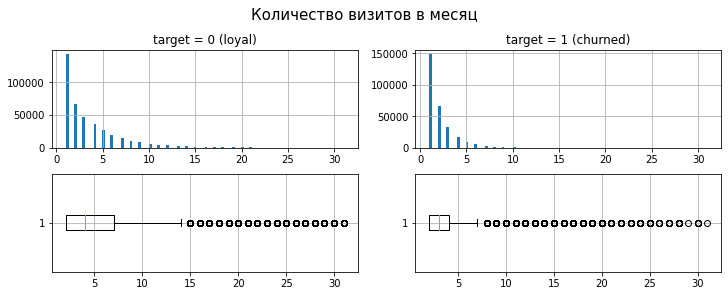

mean           median       min        max      
target                         0         1      0    1    0    1     0     1
num_of_visits_per_month  3.73954  2.132822    2.0  1.0  1.0  1.0  31.0  31.0

In [ ]:
compare_2_groups_plot('num_of_visits_per_month', 'Количество визитов в месяц', 
                      df=data_for_eda, 
                      mask_0=data_for_eda['target'] == 0, 
                      mask_1=data_for_eda['target'] == 1);

Клиенты из "не-оттока" посещали пекраню в среднем 3 раза в месяц (2 раза по медиане), из "оттока" - 2 раза в месяц (1 раз по медиане).  

Посмотрим также на статистику по количеству посещений в месяц без клиентов с 1-м посещением отнесенных к классу 0.

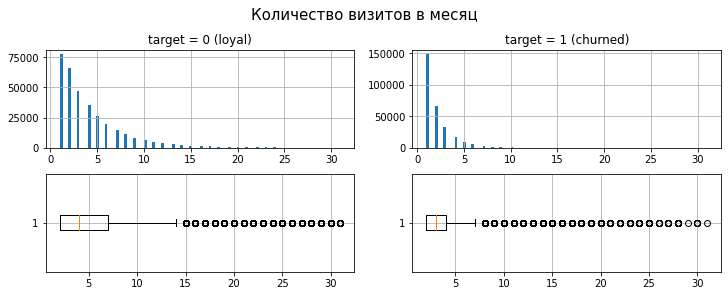

mean           median       min        max      
target                          0         1      0    1    0    1     0     1
num_of_visits_per_month  4.265452  2.132822    3.0  1.0  1.0  1.0  31.0  31.0

In [ ]:
compare_2_groups_plot('num_of_visits_per_month', 'Количество визитов в месяц', 
                      df=data_for_eda[~(data_for_eda['clnt_ID'].isin(non_churn_visited_once_IDs))], 
                      mask_0=data_for_eda['target'] == 0, 
                      mask_1=data_for_eda['target'] == 1);

Клиенты из "не-оттока", посетившие пекарню более 1-го раза, в среднем посещали кофейню 4 раза в месяц (3 раза по медиане), в то время как клиенты из "оттока" посещали 2 раза в месяц в среднем (1 раз по медиане)

### 3.4 Есть ли различия в среднем количестве визитов в неделю (`avg_num_of_visits_per_week`)?
 
  

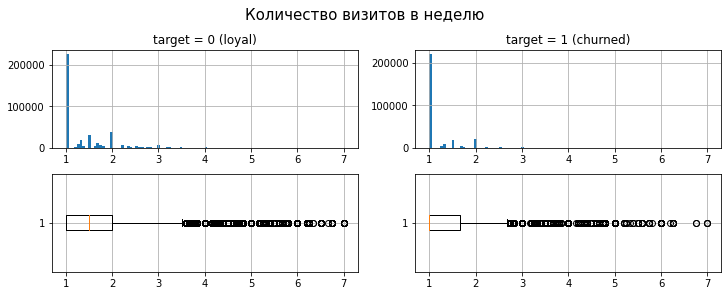

mean          median       min       max     
target                             0        1      0    1    0    1    0    1
avg_num_of_visits_per_week  1.424673  1.18857    1.0  1.0  1.0  1.0  7.0  7.0

-------------------


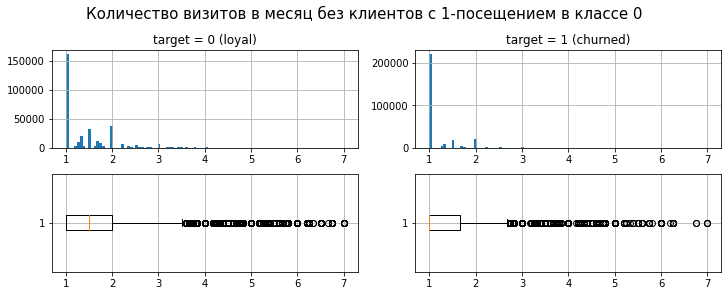

mean          median       min       max     
target                             0        1      0    1    0    1    0    1
avg_num_of_visits_per_week  1.506198  1.18857   1.25  1.0  1.0  1.0  7.0  7.0

In [ ]:
compare_2_groups_plot('avg_num_of_visits_per_week', 'Количество визитов в неделю', 
                      df=data_for_eda, 
                      mask_0=data_for_eda['target'] == 0, 
                      mask_1=data_for_eda['target'] == 1);
print('-------------------')
compare_2_groups_plot('avg_num_of_visits_per_week', 'Количество визитов в месяц без клиентов с 1-посещением в классе 0', 
                      df=data_for_eda[~(data_for_eda['clnt_ID'].isin(non_churn_visited_once_IDs))], 
                      mask_0=data_for_eda['target'] == 0, 
                      mask_1=data_for_eda['target'] == 1);

В целом, среднее количество визитов в неделю в обоих группах клиентов примерно одинково.  
У гостей из "не-отток" оно незначительно выше.

### 3.5 Есть ли различия в среднем количестве покупок в день (`avg_num_of_purch_per_day`)?


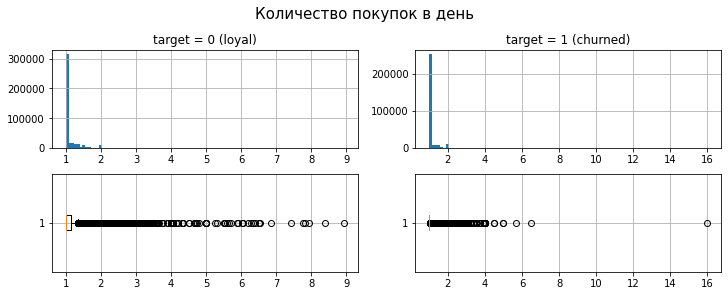

mean           median       min            max  \
target                           0         1      0    1    0    1         0   
avg_num_of_purch_per_day  1.091677  1.080855    1.0  1.0  1.0  1.0  8.923077   

                                
target                       1  
avg_num_of_purch_per_day  16.0

-------------------


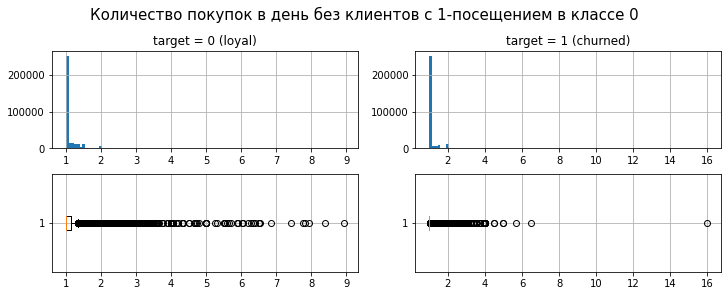

mean           median       min            max  \
target                           0         1      0    1    0    1         0   
avg_num_of_purch_per_day  1.098095  1.080855    1.0  1.0  1.0  1.0  8.923077   

                                
target                       1  
avg_num_of_purch_per_day  16.0

In [ ]:
compare_2_groups_plot('avg_num_of_purch_per_day', 'Количество покупок в день', 
                      df=data_for_eda, 
                      mask_0=data_for_eda['target'] == 0, 
                      mask_1=data_for_eda['target'] == 1);
print('-------------------')
compare_2_groups_plot('avg_num_of_purch_per_day', 'Количество покупок в день без клиентов с 1-посещением в классе 0', 
                      df=data_for_eda[~(data_for_eda['clnt_ID'].isin(non_churn_visited_once_IDs))], 
                      mask_0=data_for_eda['target'] == 0, 
                      mask_1=data_for_eda['target'] == 1);

Среднее количество покупок в день примерно одинаковое между двумя группами клиентов.

###3.6 Есть ли различия в среднем интервале между визитами (`avg_days_btw_visits`)?

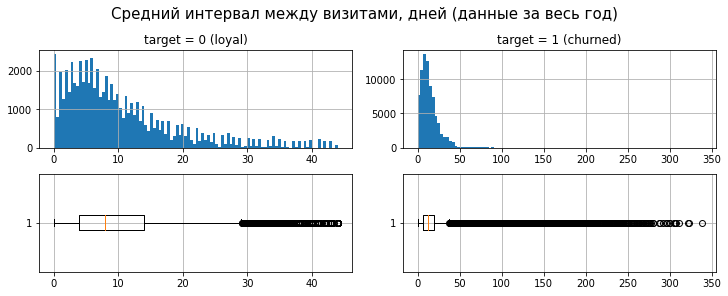

mean            median        min        max       
target                       0          1      0     1    0    1     0      1
avg_days_btw_visits  10.415353  16.084658    8.0  12.0  0.0  0.0  44.0  338.0

---------------


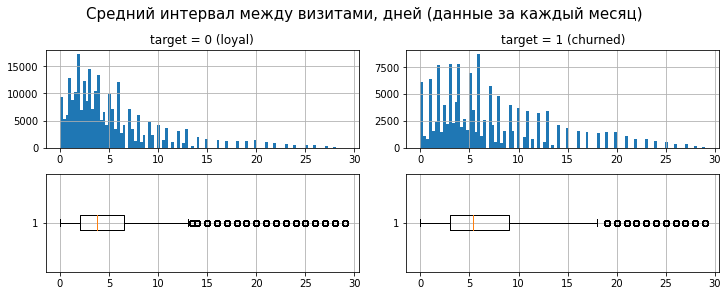

mean           median            min        max      
target                      0         1      0         1    0    1     0     1
avg_days_btw_visits  5.085732  6.793578    3.8  5.333333  0.0  0.0  29.0  29.0

In [ ]:
compare_2_groups_plot('avg_days_btw_visits', 'Средний интервал между визитами, дней (данные за весь год)');
print('---------------')
compare_2_groups_plot('avg_days_btw_visits', 'Средний интервал между визитами, дней (данные за каждый месяц)', 
                      df=data_for_eda, 
                      mask_0=data_for_eda['target'] == 0, 
                      mask_1=data_for_eda['target'] == 1);

В среднем у клиентов из "не-оттока" средний интервал составляет 5 дней (3.8 по медиане), а то время как у клиентов из "оттока" этот показатель равен 6 дням (5.4 по медиане)

Проверим, есть ли в таблице клиенты которые посетили кафе лишь раз и отнесены к категории "не-отток".  
 
UPD: Такие клиенты есть. Они отнесены к категории "не-отток", так как для таких клиентов нам не интересно предсказывать отток. Эти клиенты посетили нас лишь раз и их можно выделить в отдельную категорию.  
Нас интересуют лишь клиенты с количеством посещениий 2 и более.

In [ ]:
# Выведем на экран количество клиентов из не-оттока с 1-м посещением в каждом месяце
(
    data[data['clnt_ID'].isin(non_churn_visited_once_IDs)]
    .month
    .value_counts()
    .sort_index()
    )

1     6582
2     5682
3     7213
4     5578
5     6031
6     5611
7     4505
8     5375
9     5410
10    6107
11    6440
12    4069
Name: month, dtype: int64

Каждый месяц таких клиентов у нас в среднем 4000 - 5000 человек. 

#### Гипотеза 1. Почему клиенты, которые пришли в декабре получили флаг "ушедший"? Ведь данных о будущем нет. Возможно, метка сделана на основании предыдущего поведения.

Гипотеза: чтобы выдать клиенту флаг "ушедший", нам необходимо последить за ним еще минимум 45 дней. Таким образом, если клиент посетил кофейню в декабре, мы не можем дать ему флаг "ушедший". Однако такие клиенты есть - их 185 человек.  
Можем предположить, что такие клиенты посещали нас несколько раз, и в их посещениях был промежуток более 45 дней. Тогда, на основании этого ему могли присвоить соответсвующий флаг.

Что мы сделаем, чтобы это проверить:
- Возмем айди декабрьских клиентов-ушедших.  
- Посмотрим, сколько раз они посещали нас за год.  
- И с каким промежутком.

In [ ]:
# Создадим таблицу с ID клиентов, которые последний раз были в декабре и получили флаг "ушедшие"
clients_churned_in_december = data[lambda x: (x['month'] == 12) & (x['target'] == 1)].drop_duplicates(subset='clnt_ID')['clnt_ID']
print(clients_churned_in_december.shape)
clients_churned_in_december.sample(2)

(185,)


2106105    E1E586C4-597E-433E-B95A-5910A6E418CC
907548     30656CEC-8F2E-4E22-BA08-E83FFFDB2706
Name: clnt_ID, dtype: object

In [ ]:
# Оставим в общей таблице транзакций только данные о клиентах из списка "clients_churned_in_december"
data_with_clients_churned_in_december = data[lambda x: x['clnt_ID'].isin(clients_churned_in_december)]
print(data_with_clients_churned_in_december.shape)
data_with_clients_churned_in_december.sample(2)

(2007, 19)


,clnt_ID,timestamp,gest_Sum,gest_Discount,target,discount,date,month,num_of_week,day_of_week,hour,is_working_day,is_weekend,is_day_part_1,is_day_part_2,is_day_part_3,is_day_part_4,purchase_stamp,disc_purchase_stamp
469416,608B1CF6-36C9-4021-A272-485ADFE49FD5,2021-04-03 16:35:26.500,86.199997,1.8,1,0.020455,2021-04-03,4,13,6,16,0,1,0,0,1,0,1,1
104057,1F8D970C-2E8C-4AE4-B9FD-02212208A34B,2021-09-26 10:40:17.190,493.000000,21.0,1,0.040856,2021-09-26,9,38,0,10,1,0,0,1,0,0,1,1


In [ ]:
# Посмотрим, сколько визитов сделали данные клиенты за год.
num_of_visits_churned_in_december = data_with_clients_churned_in_december.groupby(['clnt_ID'])['date'].nunique()
num_of_visits_churned_in_december.head()

clnt_ID
0122FC32-5D1D-47D8-9A3A-D2DB66B18215    2
024F009D-C9D4-4B47-A924-36C1350E585A    2
03CDEB94-F8B5-45E1-9316-1A6C3DBD11F1    3
05880764-D564-42C6-8C95-848997CB2EF8    8
070DBC90-9CCD-4C42-9562-D12209F8DD47    4
Name: date, dtype: int64

In [ ]:
# Создадим функцию, которая возвращает словарь. В словаре ключ - между номерами каких визитов был пропуск в более чем 45 дней, значение - сам интервал между посещениями
def list_days_delta(sorted_dates): 
  sorted_dates = list(sorted_dates)
  deltas = {}
  if len(sorted_dates) == 1:
    return np.nan
  else:
    for i in range(1, len(sorted_dates)):
      delta = sorted_dates[i] - sorted_dates[i-1]
      delta = delta.days - 1
      if delta >= 45:
       deltas[f'{i} - {i+1}'] = delta

    return deltas

In [ ]:
# Создадим таблицу. Индекс - клиентский ID, значение - длительность визита (более 45 дней) и когда данный интервал был зафиксирован
list_of_deltas = data_with_clients_churned_in_december.groupby('clnt_ID')['date'].unique().apply(list_days_delta)
print(list_of_deltas.shape)
list_of_deltas.head()

(185,)


clnt_ID
0122FC32-5D1D-47D8-9A3A-D2DB66B18215     {'1 - 2': 74}
024F009D-C9D4-4B47-A924-36C1350E585A     {'1 - 2': 51}
03CDEB94-F8B5-45E1-9316-1A6C3DBD11F1    {'2 - 3': 311}
05880764-D564-42C6-8C95-848997CB2EF8     {'7 - 8': 57}
070DBC90-9CCD-4C42-9562-D12209F8DD47     {'3 - 4': 79}
Name: date, dtype: object

In [ ]:
# Отфильтруем клиентов, посетивших нас более 1-го раза и имеющих интервалы между визитами 45 и более дней
list_of_deltas_df = pd.DataFrame(list_of_deltas)
print(list_of_deltas_df[lambda x: (x['date'] != {}) & (x['date'] != 0)].shape)
list_of_deltas_df[lambda x: (x['date'] != {}) & (x['date'] != 0)].head()

(183, 1)


,date
clnt_ID,
0122FC32-5D1D-47D8-9A3A-D2DB66B18215,{'1 - 2': 74}
024F009D-C9D4-4B47-A924-36C1350E585A,{'1 - 2': 51}
03CDEB94-F8B5-45E1-9316-1A6C3DBD11F1,{'2 - 3': 311}
05880764-D564-42C6-8C95-848997CB2EF8,{'7 - 8': 57}
070DBC90-9CCD-4C42-9562-D12209F8DD47,{'3 - 4': 79}


In [ ]:
# Посмотрим на 2=х клиентов, которые посетили кафе более 1-го раза при этом с интервалом менее 45 дней, из категории ушедших
list_of_deltas_df[lambda x: (x['date'] == {}) | (x['date'] == 0)]

,date
clnt_ID,
AF70DE30-BCDA-4147-873E-038EC7F56A5A,{}
B4D8BCA8-218F-48A6-A120-A161ED287D45,{}


Два клиента посетили кафе более 1-го раза (один из разов - в декабре), однако с интервалами не превышающими 45 дней.

In [ ]:
data_new[data_new['clnt_ID'].isin(['AF70DE30-BCDA-4147-873E-038EC7F56A5A', 'B4D8BCA8-218F-48A6-A120-A161ED287D45'])]

,clnt_ID,total_num_of_purchases,total_num_of_visits_per_year,avg_num_of_visits_per_month,avg_num_of_visits_per_week,avg_num_of_purch_per_day,avg_days_btw_visits,total_spend_per_year,avg_spend_per_month,avg_spend_per_week,avg_spend_per_day,avg_bill_per_transaction,avg_discount_per_purchase,purch_with_discount_ratio,target
174329,AF70DE30-BCDA-4147-873E-038EC7F56A5A,2,2,1.0,1.0,1.0,44.0,1300.000000,650.000000,650.000000,650.000000,650.000000,0.000000,0.0,1
179901,B4D8BCA8-218F-48A6-A120-A161ED287D45,2,2,1.0,1.0,1.0,44.0,1075.299988,537.649994,537.649994,537.649994,537.649994,0.067123,1.0,1


У данных клиентов, интервал равняется 44 дням. Однако можно вспомнить, что и у лояльных клиентов встречался такой интервал. Интересно, как они тут очутились :)

**Краткий итог**  
Количество объектов, удовлетворяющим условия "хоть раз посетил кафе с промежутком 45 дней и более" равняется 183. Они посетили кафе в декабре и получили метку "ушедший". 
Видимо это те клиенты, у которых интервал между предпоследним и последним визитом был более 45 дней.  
Проверим, так ли это.

P.S.
Также есть два клиента, последнее посещение которых пришлось на декабрь, однако промежутки между их визитами были менее 45 дней. Почему они попали в категорию "отток"?


In [ ]:
# Добавим в таблицу "list_of_deltas_df" общее количество визитов
tmp = list_of_deltas_df[lambda x: (x['date'] != {}) & (x['date'] != 0)].join(num_of_visits_churned_in_december, rsuffix='_num_of_visits')

# Создадим столбец, в который сохраним последний день, перед которым был интервал более 45 дней
day_of_visit_after_big_interval = pd.Series(
                                            tmp.apply(
                                                      lambda row: int(
                                                                      re.findall('\d+', list(row[0].keys())[-1])[-1]
                                                                      ), 
                                                      axis=1
                                                      ), 
                                            name='day_of_visit_after_big_interval'
                                            )

# Добавим столбец "day_of_visit_after_big_interval" к общей таблице 
tmp_1 = tmp.join(day_of_visit_after_big_interval)

# Выведем на экран количество клиентов, для которых последний день визита совпал с днем, перед которым был интервал более 45 дней
print(
    f'''Rоличество клиентов, для которых последний день визита совпал с днем, перед которым был интервал более 45 дней:
    {(tmp_1['date_num_of_visits'] == tmp_1['day_of_visit_after_big_interval']).sum()}
    Всего клиентов пришедших в декабре и получивших метку "отток": {list_of_deltas_df.shape[0]}
    '''
 )

Rоличество клиентов, для которых последний день визита совпал с днем, перед которым был интервал более 45 дней:
    183
    Всего клиентов пришедших в декабре и получивших метку "отток": 185
    


Получается, что гости, посетившие кафе в последний месяц в декабре получили метку "ушедший" на основании того, что в последний раз они посещали кафе более 45 дней назад.

Это означает, что если **клиент посетил кофейню более 1-го раза, и при этом между его визитами имеется интервал 45 дней и более - мы относим его к категории "ушедших" (даже если после этого интервала он посетил нас еще раз!)**  
UPD: Заказчик дал обратную связь, что в данные не должна была попасть информацию о посещениях клиента спустя интервал более 45 дней. Такие посещения удалялись из таблицы.

#### Гипотеза 2. Попытка понять, на основании чего проставлялись метки классов

Проверим, есть ли среди клиентов, посетивших нас в декабре и отмеченных как "не-отток" пропуски в более чем 45 дней.

In [ ]:
# Создадим функцию, которая будет считать количество пропусков 45 дней и более
def count_45plus_days_delta(sorted_dates): 
  sorted_dates = list(sorted_dates)
  deltas = []
  if len(sorted_dates) == 1:
    return np.nan
  else:
    for i in range(1, len(sorted_dates)):
      delta = sorted_dates[i] - sorted_dates[i-1]
      delta = delta.days - 1
      if delta >= 45:
        deltas.append(delta)
    return len(deltas)

In [ ]:
num_of_45plus_deltas = data.groupby('clnt_ID')['date'].unique().apply(count_45plus_days_delta)[lambda x: x > 0]

In [ ]:
# Присоеденим к таблице "num_of_45plus_deltas" таргет и посмотрим на количество лояльных клиентов в таблице
pd.DataFrame(num_of_45plus_deltas).merge(target, on='clnt_ID')[lambda x: x['target'] == 0]

,clnt_ID,date,target


В таблице нет ни одного клиента категории "не-отток", у которого интервал между посещениями был бы 45 дней и более.  
**Это может означать, что все клиенты, у которых такой интервал был хотя бы раз - действительно отнесены к категории "ушедших"**  
UPD: Заказчик подтвердил - если у клиента был интервал между посещениям 45 и более дней, ему сразу ставится метка "отток"

Интересно, а есть ли гости, которые относятся к категории "ушедшие", но не имеют интервалов в предыдущих посещениях более 45 дней? Если таковые имеются, это может означать, что данный флаг ставится не только на основании интервала "предпоследнее посещение" - "последнее посещение", но и на оснвании интервала "последнее посещение" - "сегодня".     
  
Итак: 
- Берем ушедших клиентов
- Убираем тех, у кого лишь одно посещение
- Убираем все, у кого есть хоть один интрвал в 45 дней между визитами

In [ ]:
churn_IDs = data_new[data_new['target'] == 1]['clnt_ID'].values
more_then_one_visit_IDs = data_new[data_new['total_num_of_visits_per_year'] > 1]['clnt_ID'].values
churn_and_more_than_one_visit_mask = data['clnt_ID'].isin(churn_IDs) & (data['clnt_ID'].isin(more_then_one_visit_IDs))

In [ ]:
data[churn_and_more_than_one_visit_mask].groupby('clnt_ID')['date'].unique().apply(count_45plus_days_delta).value_counts()

0    74903
1     4582
Name: date, dtype: int64

В наших данных есть 74903 клиента из категории "отток", которые посетили кофейню 2 и более раз и при ни разу интервал между их визитами не не превышал 45 дней.

Тогда, наверное от их последнего визита до 31.12.21 должно было пройти более 45 дней. Проверим, так ли это.  
Для этого:
- Оставим в таблице только "ушедших клиентов", в истории посещений которых нет интервалов превышающих 45 дней
- Оставим в таблице лишь строку с последней транзакцией клиента
- Вычислим разницу между датой последнего посещения и 31.12.21  

Все полученные значения должны быть более 45 дней, чтобы гипотеза подтвердилась.

In [ ]:
# Возмем ID ушедших клиентов, у которых в истории нет интервалов более 45 дней.
list_of_churned_delta_only_less_then_45d = data[churn_and_more_than_one_visit_mask].groupby('clnt_ID')['date'].unique().apply(count_45plus_days_delta)[lambda x: x == 0].index.to_list()

In [ ]:
churned_clnt_last_visit_date = data[data['clnt_ID'].isin(list_of_churned_delta_only_less_then_45d)].drop_duplicates(subset='clnt_ID', keep='last')
days_after_last_visit = datetime.date(2021, 12, 31) - churned_clnt_last_visit_date['date']
full_table = churned_clnt_last_visit_date.join(days_after_last_visit.apply(lambda x: x.days), rsuffix='days_after_last_vist')

Посмотрим в какие месяцы (и в каком количестве) последний раз приходили клиенты, которые:
- Относятся к классу "ушедшие"
- Не имеют интервалы 45 дней и более в истории посещений
- Количество дней между их последним визитом и 31.12.21 также менее 45 дней

In [ ]:
full_table[full_table['datedays_after_last_vist'] < 45] #['month'].value_counts()

,clnt_ID,timestamp,gest_Sum,gest_Discount,target,discount,date,month,num_of_week,day_of_week,hour,is_working_day,is_weekend,is_day_part_1,is_day_part_2,is_day_part_3,is_day_part_4,purchase_stamp,disc_purchase_stamp,datedays_after_last_vist
1825733,CA2F7E09-165E-4D29-8A8C-A94F1F94D90D,2021-11-30 18:16:57.480,470.399994,9.600000,1,0.020000,2021-11-30,11,48,2,18,1,0,0,0,1,0,1,1,31
2296546,2468CC71-DC2F-4D6B-B77D-549147151EAB,2021-11-17 14:09:58.357,328.000000,30.000000,1,0.083799,2021-11-17,11,46,3,14,1,0,0,1,0,0,1,1,44
2331522,B4D8BCA8-218F-48A6-A120-A161ED287D45,2021-12-05 16:41:49.987,675.799988,54.200001,1,0.074247,2021-12-05,12,48,0,16,1,0,0,0,1,0,1,1,26
2333792,AF70DE30-BCDA-4147-873E-038EC7F56A5A,2021-12-07 20:40:07.920,500.000000,0.000000,1,0.000000,2021-12-07,12,49,2,20,1,0,0,0,0,1,1,0,24


Из 74903 клиентов таких всего лишь 4. Они были в ноябре и в декабре.  
У остальных интервал от их последнего посещения до 31.12.21 действительно более 45 дней.

**UPD: Заказчик сказал, что последние посещения у клиентов из "оттока", перед которым был интервал в 45 и более дней в большинстве своем удалены.**

#### Краткий итог  

Основые пункты, на которые стоит обратить вниманеи:  
- В данных присутствуют клиенты в категории "не-отток" всего лишь с 1-м посещением. Они отнесены к данной категории так как нам не интересно предсказывать для них отток. Это отдельная категория клиентов, и они не относятся к "оттоку". К оттоку относятся клиенты, посетившие нас более 1 раза, и между посещениями у которых есть интервал 45 дней и более.
- Есть 2 клиента, которые посетили кафе более 1-го раза (один из разов - в декабре), однако с интервалами не превышающими 45 дней. При этом они отнесены к классу "отток", хотя от их последнего посещения до даты отсечки также не прошло 45 дней.



### 3.7 Есть ли различия в общей сумме трат за период (год) (`total_spend_per_year`)?

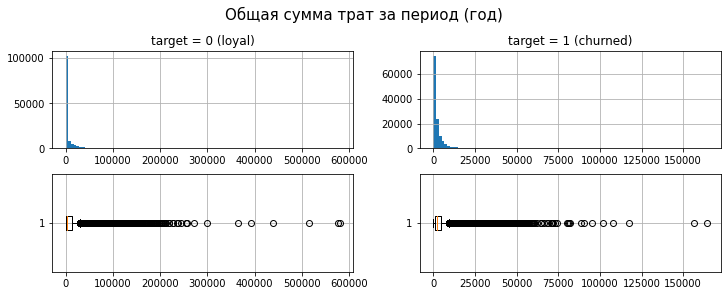

mean               median          min       \
target                          0            1       0       1    0    1   
total_spend_per_year  5783.878097  2598.791503  1200.0  1239.0  0.0  0.0   

                                max                 
target                            0              1  
total_spend_per_year  579780.800251  164596.719162

--------------


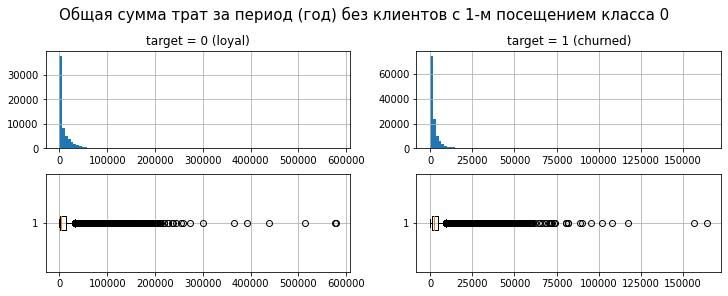

mean                    median          min  \
target                           0            1            0       1    0   
total_spend_per_year  10805.440485  2598.791503  3710.749992  1239.0  0.0   

                                     max                 
target                  1              0              1  
total_spend_per_year  0.0  579780.800251  164596.719162

In [ ]:
compare_2_groups_plot('total_spend_per_year', 'Общая сумма трат за период (год)');
print('--------------')
compare_2_groups_plot('total_spend_per_year', 'Общая сумма трат за период (год) без клиентов с 1-м посещением класса 0', 
                      df=data_new[~data_new['clnt_ID'].isin(non_churn_visited_once_IDs)]);



Есть явные различия в средних тратах: клиенты из группы "не-отток" за год потратили в среднем 10805р (3710р по медиане), в то время как клиенты из "оттока" потратили лишь 2598р (1239р по медиане).

При этом есть нулевые траты в обоих группах ячеек. Видимо, это случаи, когда клиенты получали что-либо бесплатно.

In [ ]:
data[data['gest_Sum'] == 0].head()

,clnt_ID,timestamp,gest_Sum,gest_Discount,target,discount,date,month,num_of_week,day_of_week,hour,is_working_day,is_weekend,is_day_part_1,is_day_part_2,is_day_part_3,is_day_part_4,purchase_stamp,disc_purchase_stamp
200,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-11-01 09:39:13.290,0.0,0.0,0,1.0,2021-11-01,11,44,1,9,1,0,1,0,0,0,1,1
673,F16BCF77-FA5A-4093-B7E3-FA86E2B1EA31,2021-11-10 09:11:40.580,0.0,0.0,0,1.0,2021-11-10,11,45,3,9,1,0,1,0,0,0,1,1
1619,E4D6DECC-7344-4A95-A4F9-E065DBED3430,2021-05-29 21:43:50.843,0.0,0.0,1,1.0,2021-05-29,5,21,6,21,0,1,0,0,0,1,1,1
2855,BC0AC57F-D23E-4B1E-8889-1454377B33E4,2021-02-10 14:52:00.383,0.0,0.0,0,1.0,2021-02-10,2,6,3,14,1,0,0,1,0,0,1,1
3441,F7C3D721-F9D6-4FCC-8401-BD5AEACCF2EE,2021-08-17 16:28:43.340,0.0,0.0,0,1.0,2021-08-17,8,33,2,16,1,0,0,0,1,0,1,1


In [ ]:
data[data['gest_Sum'] == 0]['target'].value_counts()

0    2760
1     942
Name: target, dtype: int64

Интересно, что сумма скидки также равна нулю. Возможно, стоит уточнить у закзачика, с чем связаны такие чеки.  
При чем у клиентов из "не-оттока", таких чеков больше.

Посмотрим на данные о новых клиентах (оставляем в таблице лишь первое посещение). Посчитаем количество ушедших и лояльных клиентов среди тех, кто получил что-то бесплатно.

In [ ]:
data.drop_duplicates(keep='first')[lambda x: x['gest_Sum'] == 0].target.value_counts(normalize=True)

0    0.745543
1    0.254457
Name: target, dtype: float64

Видимо, это акция, в рамках которой гость получает что-то бесплатно в свой первый визит. Из всех новых гостей, которые получили такой подарок, 74,5% - отнесены в категорию "не-отток", а 25,4% - ушли в отток.  
Посмотрим теперь на данные о новых клиентах, которые не получили бесплатное что-то. Посчитаем количество ушедших и лояльных.

In [ ]:
data.drop_duplicates(keep='first')[lambda x: x['gest_Sum'] != 0].target.value_counts(normalize=True)

0    0.716673
1    0.283327
Name: target, dtype: float64

Среди клиентов, которые не получили бесплатный подарок в свой первый визит, распределение лояльных и ушедших примерно такое же.

### 3.8 Есть ли различия в среднем объеме трат в месяц (`spend_per_month`)?

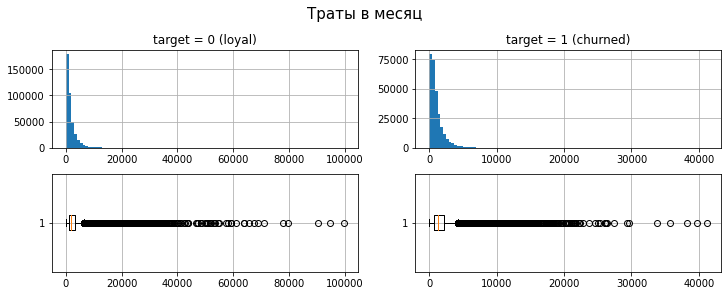

mean                    median         min       \
target                     0            1            0      1    0    1   
spend_per_month  1851.572671  1137.452158  1151.160034  760.0  0.0  0.0   

                          max               
target                      0            1  
spend_per_month  99721.000351  41256.45005

-------------------


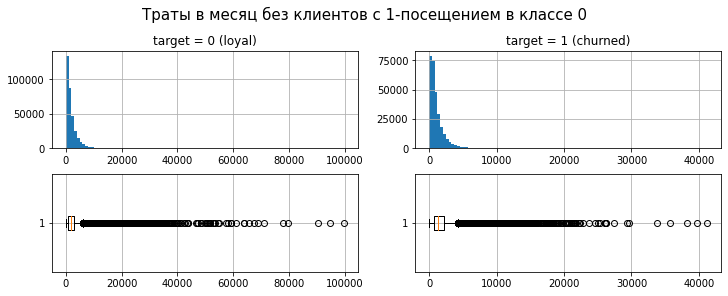

mean                    median         min       \
target                     0            1            0      1    0    1   
spend_per_month  2048.826606  1137.452158  1306.999971  760.0  0.0  0.0   

                          max               
target                      0            1  
spend_per_month  99721.000351  41256.45005

In [ ]:
compare_2_groups_plot('spend_per_month', 'Траты в месяц', 
                      df=data_for_eda, 
                      mask_0=data_for_eda['target'] == 0, 
                      mask_1=data_for_eda['target'] == 1);
print('-------------------')
compare_2_groups_plot('spend_per_month', 'Траты в месяц без клиентов с 1-посещением в классе 0', 
                      df=data_for_eda[~(data_for_eda['clnt_ID'].isin(non_churn_visited_once_IDs))], 
                      mask_0=data_for_eda['target'] == 0, 
                      mask_1=data_for_eda['target'] == 1);

Клиенты из "не-оттока" (с более чем 1-м посещением) в среднем тратили 2048р в месяц (1206р по медиане), в то время как клиенты из "оттока" в среднем тратили 1137р (760р по медиане).

### 3.9 Есть ли различия в среднем объеме трат в неделю (`avg_spend_per_week`)?



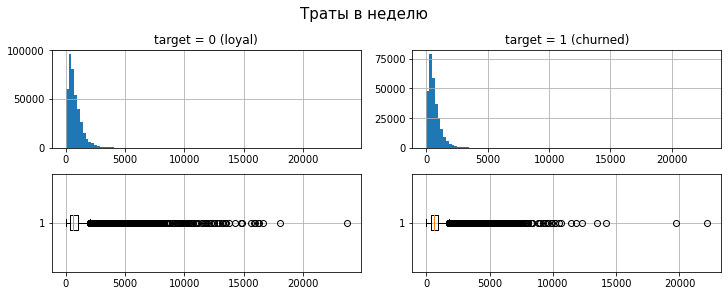

mean                  median         min       \
target                       0           1           0      1    0    1   
avg_spend_per_week  764.891691  665.243379  599.600008  518.0  0.0  0.0   

                             max           
target                         0        1  
avg_spend_per_week  23685.900001  22880.0

-------------------


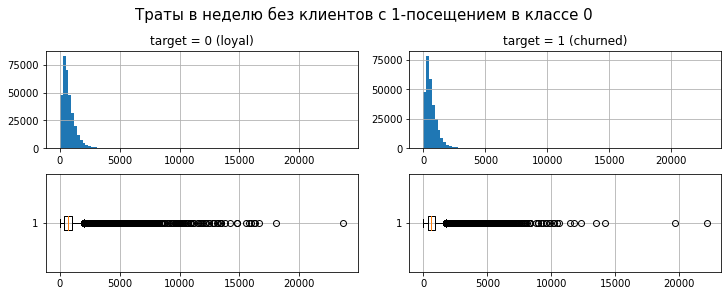

mean                  median         min       \
target                      0           1           0      1    0    1   
avg_spend_per_week  753.53462  665.243379  592.141664  518.0  0.0  0.0   

                             max           
target                         0        1  
avg_spend_per_week  23685.900001  22880.0

In [ ]:
compare_2_groups_plot('avg_spend_per_week', 'Средние траты в неделю', 
                      df=data_for_eda, 
                      mask_0=data_for_eda['target'] == 0, 
                      mask_1=data_for_eda['target'] == 1);
print('-------------------')
compare_2_groups_plot('avg_spend_per_week', 'Средние траты в неделю без клиентов с 1-посещением в классе 0', 
                      df=data_for_eda[~(data_for_eda['clnt_ID'].isin(non_churn_visited_once_IDs))], 
                      mask_0=data_for_eda['target'] == 0, 
                      mask_1=data_for_eda['target'] == 1);

В среднем, клиенты из не-оттока тратили денег в неделю больше, нежели клиенты, которые ушли в отток.

### 3.7 Есть ли различия в среднем объеме трат в день (`avg_spend_per_day`)?

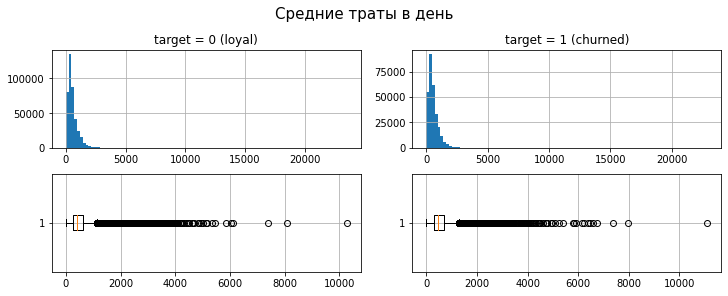

mean                  median         min       \
target                      0           1           0      1    0    1   
avg_spend_per_day  559.284907  567.415909  441.949997  450.0  0.0  0.0   

                       max           
target                   0        1  
avg_spend_per_day  23500.0  22880.0

-------------------


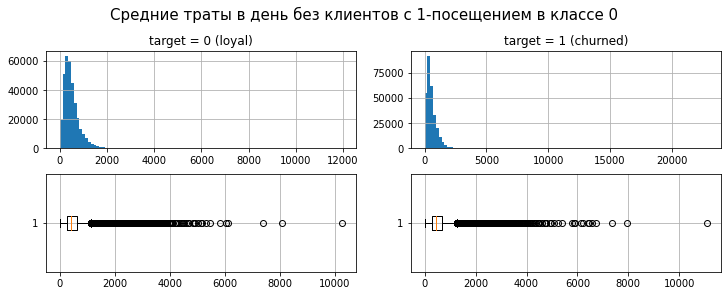

mean             median         min           max  \
target                      0           1      0      1    0    1        0   
avg_spend_per_day  508.457339  567.415909  424.0  450.0  0.0  0.0  11960.0   

                            
target                   1  
avg_spend_per_day  22880.0

In [ ]:
compare_2_groups_plot('avg_spend_per_day', 'Средние траты в день', 
                      df=data_for_eda, 
                      mask_0=data_for_eda['target'] == 0, 
                      mask_1=data_for_eda['target'] == 1);
print('-------------------')
compare_2_groups_plot('avg_spend_per_day', 'Средние траты в день без клиентов с 1-посещением в классе 0', 
                      df=data_for_eda[~(data_for_eda['clnt_ID'].isin(non_churn_visited_once_IDs))], 
                      mask_0=data_for_eda['target'] == 0, 
                      mask_1=data_for_eda['target'] == 1);

В среднем, средние дневные траты клиентов из "не-оттока" немногоим меньше, чем средние дневные траты клиентов из "оттока".  

### 3.10 Есть ли различия в размере среднего чека за 1-у транзакцию (`gest_Sum`)?


Посмотрим на распределение суммы оплат в каждом чеке за год. Чтобы отбросить выбросы, возьмем 95 квантиль.

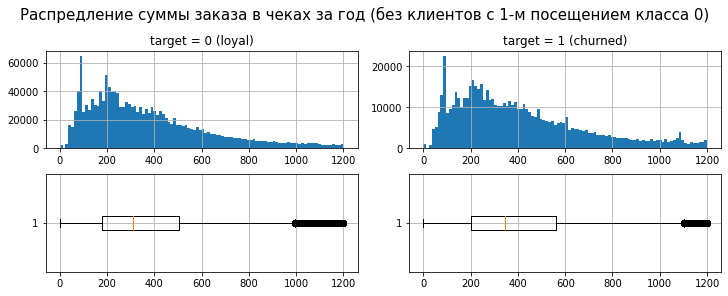

mean                  median         min              max  \
target             0           1           0      1    0    1           0   
gest_Sum  373.364939  409.277541  310.399994  347.0  0.0  0.0  1199.97998   

                       
target              1  
gest_Sum  1199.900024

In [ ]:
compare_2_groups_plot('gest_Sum', 'Распредление суммы заказа в чеках за год (без клиентов с 1-м посещением класса 0)',
                      df=data[(data['gest_Sum'] < data['gest_Sum'].quantile(.95)) & (~data['clnt_ID'].isin(non_churn_visited_once_IDs))],
                      mask_0=data['target'] == 0,
                      mask_1=data['target'] == 1);

Интересно, что клиенты "не-отток" имеют в среднем более низкий чек в расчете на одну покупку, нежели клиенты из "оттока". (Однако для того, чтобы утверждать, что разница значима необходимо проводить статистический тест.)  
При этом в рамках недели и месяца сумма их покупок привышает суммы покупок клиентов из "оттока".

### 3.11 Есть ли различия в среднем размере скидки в расчете на 1-у покупку (`avg_discount_per_purchase`)?

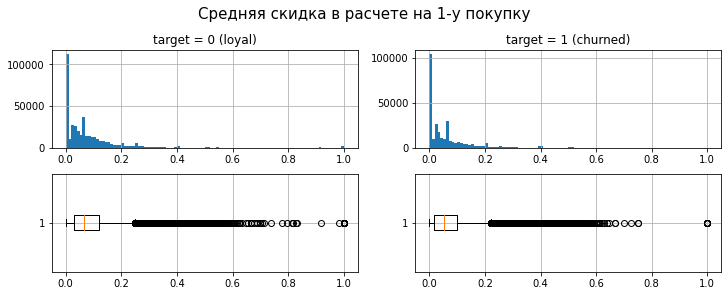

mean             median           min       max  \
target                           0        1         0        1    0    1    0   
avg_discount_per_purchase  0.08624  0.06451  0.052715  0.03006  0.0  0.0  1.0   

                                
target                       1  
avg_discount_per_purchase  1.0

-------------------


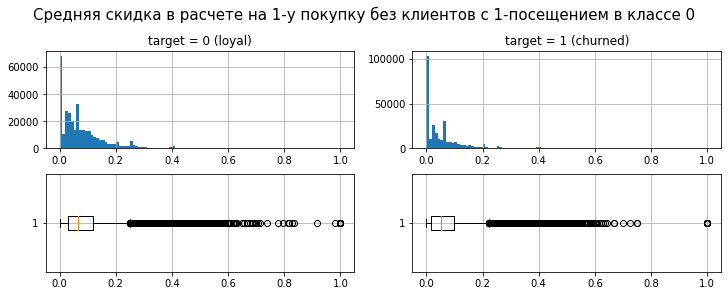

mean             median           min       \
target                            0        1         0        1    0    1   
avg_discount_per_purchase  0.081647  0.06451  0.060007  0.03006  0.0  0.0   

                           max       
target                       0    1  
avg_discount_per_purchase  1.0  1.0

In [ ]:
compare_2_groups_plot('avg_discount_per_purchase', 'Средняя скидка в расчете на 1-у покупку', 
                      df=data_for_eda, 
                      mask_0=data_for_eda['target'] == 0, 
                      mask_1=data_for_eda['target'] == 1);
print('-------------------')
compare_2_groups_plot('avg_discount_per_purchase', 'Средняя скидка в расчете на 1-у покупку без клиентов с 1-посещением в классе 0', 
                      df=data_for_eda[~(data_for_eda['clnt_ID'].isin(non_churn_visited_once_IDs))], 
                      mask_0=data_for_eda['target'] == 0, 
                      mask_1=data_for_eda['target'] == 1);

В среднем, средняя скидка в расчете на одну покупку выше у клиентов из "не-оттока", нежели у клиентов из "оттока".

### 3.12 Есть ли различия в доле покупок со скидкой в общем количестве покупок в течение месяца (`purch_with_discount_ratio`)?

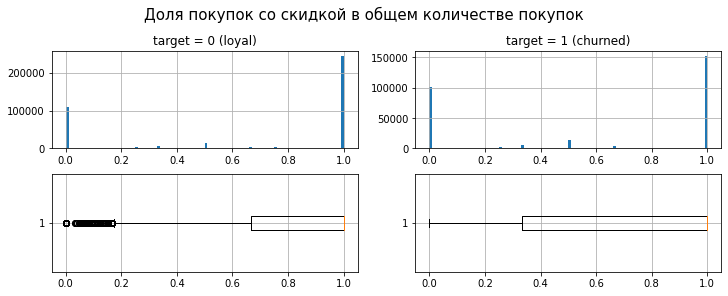

mean           median       min       max     
target                           0         1      0    1    0    1    0    1
purch_with_discount_ratio  0.67096  0.587807    1.0  1.0  0.0  0.0  1.0  1.0

-------------------


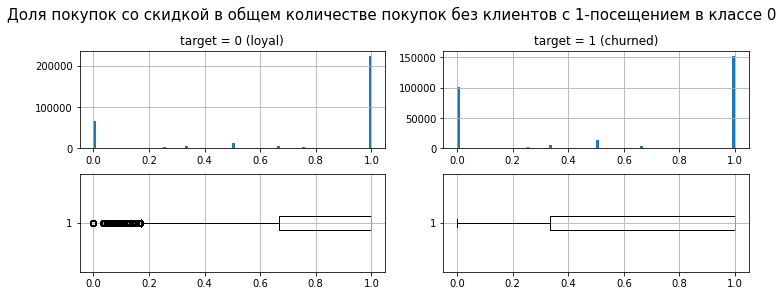

mean           median       min       max     
target                          0         1      0    1    0    1    0    1
purch_with_discount_ratio  0.7376  0.587807    1.0  1.0  0.0  0.0  1.0  1.0

In [ ]:
compare_2_groups_plot('purch_with_discount_ratio', 'Доля покупок со скидкой в общем количестве покупок', 
                      df=data_for_eda, 
                      mask_0=data_for_eda['target'] == 0, 
                      mask_1=data_for_eda['target'] == 1);
print('-------------------')
compare_2_groups_plot('purch_with_discount_ratio', 'Доля покупок со скидкой в общем количестве покупок без клиентов с 1-посещением в классе 0', 
                      df=data_for_eda[~(data_for_eda['clnt_ID'].isin(non_churn_visited_once_IDs))], 
                      mask_0=data_for_eda['target'] == 0, 
                      mask_1=data_for_eda['target'] == 1);

Доля покупок со скидкой у клиентов из "не-оттока" выше, нежели у "ушедших" гостей.

### 3.13 Есть ли зависимость целевого показателя от часа либо дня недели?

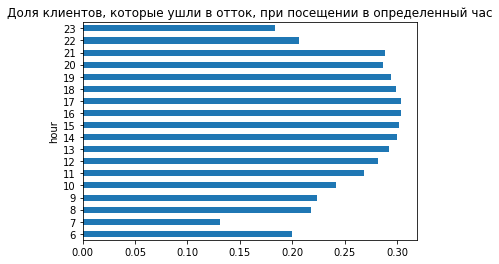

-----------------


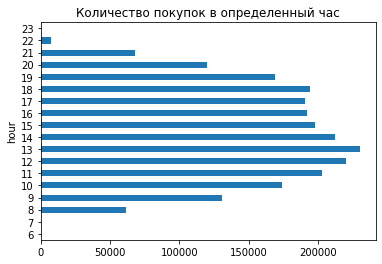

In [ ]:
data.groupby('hour')['target'].mean().plot.barh();
plt.title('Доля клиентов, которые ушли в отток, при посещении в определенный час')
plt.show()
print('-----------------')
data.groupby('hour')['timestamp'].count().plot.barh();
plt.title('Количество покупок в определенный час')
plt.show()

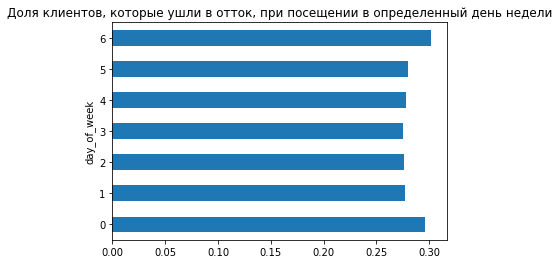

-----------------


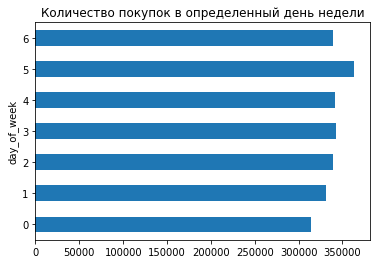

In [ ]:
data.groupby('day_of_week')['target'].mean().plot.barh();
plt.title('Доля клиентов, которые ушли в отток, при посещении в определенный день недели')
plt.show()
print('-----------------')
data.groupby('day_of_week')['timestamp'].count().plot.barh();
plt.title('Количество покупок в определенный день недели')
plt.show()

Какой-либо явной корреляции дня недели либо часа с целевым показателем обнаружить не удалось.



### Резюме

В ходе проведенного анализа, удалось заметить, что:  
- В среднем, траты клиентов из "не-отток" в рамках недели, месяца и года выше, нежели траты "ушедших" клиентов.  При этом в рамках 1-го дня клиенты "не-оттока" в среднем тратят немногим меньше, нежели клиенты из "оттока".  
- Размер скидки у "не-ушедших" гостей выше, чем у гостей "ушедших". То же справдливо и в отношении доли покупок со скидкой в общем количестве покупок за месяц.  
- "Не-ушедшие" клиенты в среднем посещают кофейню чаще и с меньшими интревалами, нежели клиенты, которые ушли в "отток".

# 4. Постановка задачи машинного обучения. Подготовка данных. Проверка базовых моделей.

В решении данной задачи можно использовать 2 подхода:  
1. "Динамический".  
В рамках данного подохода, клиенту проставляется метка "1" только если между его текущим и следующим посещением (либо текущей датой) прошло 45 дней и более. Соответсвенно, один и тот же клиент в разные моменты времени может иметь разные метки класса.  
2. "Статистический".  
В данном случае, мы делаем предположение, что клиенты "не-отток" и клиенты "отток" в среднем ведут себя по разному. Таким образом, мы будем создавать признаковое описание для данных клиентов на основе их поведения за определенный период.  
  
В рамках того, как задача поставлена заказчиком, будем руководствоваться подходом номер 2: "статистическим".  


Предложение к тому, как может применяться модель:  
- Модель можно использовать каждый месяц. Первого числа нового месяца предлагается собирать данные о клиентах за прошедший месяц, предобрабаотывать их соответсвующим образом и строить для каждого клиента предсказание.
- 30 дней - это меньше чем количество дней, после которого мы считаем клиента ушедшим, а значит достаточно раз в 30 дней проверять клиентов на предмет оттока.
- В нашем распоряжении будут данные о поведении пользователя за прошедшие 30 дней - а значит на основании этих данных уже можно вычислять какие-то показатели, описывающие поведение гостей.  
- В качестве тренировочного датасета мы будем использовать данные, предобработанные следующим образом:  
  - Берем 1 месяц -> группируем по клиентам -> для каждого клиента вычисляем необходимые показатели -> потворяем процедуру с оставшимися месяцами -> все месяца конкатенируем.  

Таким образом, мы будем иметь выборку, в которой описывается то, как клиент вел себя в течение 1 месяца и к какому классу мы его при этом отнесли.  

Интепретация предсказаний модели будет следующая: "клиент, при таком поведении в течение месяца скорее всего склонен к тому, чтобы рано или поздно допустить интервал в 45 и более дней между своими посещениями (если мы отнесли его к классу 1)"  

При этом рекомендуется не включать в данные для предсказания клиентов, которые посетили пекарню первый раз. Так, мы сможем сосредоточиться на клиентах, которые посетили нас более одного раза, а значит они не являются случайными прохожими либо туристами. С такими клиентами уже можно работать, и в перспективе, предлагать скидку.  
Также, это связано со сложность в разметке данных. К категории "отток" заказчик отнес клиентов, которые приходили к нам более 1-го раза (и значит интересны нам), но при этом допускали интервал в 45 и более дней между визитами. К категории же "не-отток" относятся как клиенты, посетившие нас более 1-го раза, и при этом продолжающие регулярно посещать кафе, так и клиенты, которые пришли к нам лишь раз и больше не возвращались (они не являются теми, кто нам интересен, и значит мы не хотим их классифицировать как "отток", т.е. как тех, кого мы бы хотели вернуть и у нас потенциально есть возможность вернуть). В сумме - это уже 3 класса.  
   
Чтобы сохранить в выборке только клиентов, с которыми нам интересно работать (а именно тех, кто посетил нас более 1-го раза), в рамках обучения модели мы уберем гостей класса "не-отток" посетивших кафе лишь единожды.  
   
В контексте же приминения модели, предлагается изсключать из выгрузки новых (первичных) клиентов. Таким образом, убирая первичных клиентов при применении модели мы оставляем лишь тех клиентов, кто уже к нам вернулся хоть раз. И для них мы можем строить предсказания "склонен к тому, чтобы прийти через 45 дней и более" = "отток", либо же "вернется менее чем через 45 дней" = "не-отток".  
 
Для клиентов, посетивших кофейню лишь единожды, предлагается разработать отдельную маркетинговую стратегию. В рамках данного проекта она рассматриваться не будет.

##  Подготовка данных и создание необходимых функций предобработки данных

Перед тем, как создавать новые признаки, данные необходимо почистить. 

- Удалим клиентов из списка `non_churn_visited_once_IDs`. Это клиенты, которые посетили нас лишь раз и были отнесены к категории лояльные.
- Удалим данные за ноябрь и декабрь, так как в них слишком большой дисбаланс классов, и могут присутствовать неточости в выставлении меток клиентам.  
- Удалим строки с посещениями клиентов, произошедших спустя 45 дней и более (`churned_last_visit_rows_ind`)  

Сохраним данные в таблицу `data_pp`

In [ ]:
data_pp = (
    data
    .drop(churned_last_visit_rows_ind, axis=0) # Удалим строки с посещениями клиентов, произошедших спустя 45 дней и более 
    .where(data['month'] < 11).dropna(axis=0) # Удалим данные за ноябрь и декабрь
    .where(~data['clnt_ID'].isin(non_churn_visited_once_IDs)).dropna(axis=0) # Удалим строки с клиентами из списка "non_churn_visited_once_IDs"
)

Также, создадим несколько полезных функций:

In [ ]:
# Зададим функцию, которая построит график PR_CURVE
def precision_recall_plot(title='PR-кривая', model=None, X=None, y=None, predicted_probas=None, ax=None):
    if isinstance(predicted_probas, type(None)):
      probabilities_valid = model.predict_proba(X)[:, 1]
    else:
      probabilities_valid = predicted_probas

    precision, recall, thresholds = precision_recall_curve(y, probabilities_valid)

    ax.step(recall, precision, where='post')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title(title)
    
# Зададим функцию, которая построит график ROC_AUC_CURVE
def roc_curve_plot(title='ROC-кривая', model=None, X=None, y=None, predicted_probas=None, ax=None):
    if isinstance(predicted_probas, type(None)):
      probabilities_valid = model.predict_proba(X)[:, 1]
    else:
      probabilities_valid = predicted_probas

    fpr, tpr, thresholds = roc_curve(y, probabilities_valid) 
    
    ax.step(fpr, tpr)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_ylim([0.0, 1.0])
    ax.set_xlim([0.0, 1.0])
    ax.set_title(title)

# Зададим функцию, которая построит 2 вышеупомянутых графика
def show_curves(model=None, X=None, y=None, predicted_probas=None, suptitle='Model Name'):
  fig, ax = plt.subplots(1, 2, figsize=(10, 5))
  fig.suptitle(suptitle)

  precision_recall_plot(model=model, X=X, y=y, predicted_probas=predicted_probas, ax=ax[0])
  roc_curve_plot(model=model, X=X, y=y, predicted_probas=predicted_probas, ax=ax[1]);

  return fig, ax


# Зададим функцию, которая выведет метрики классификации модели на валидационной/тестовой выборке.
def print_clf_metrics(y_true, predicted_probas, title, mode='predict_proba'):
  print(f'- {title} -')

  if mode == 'predict_proba':
    predictions_valid = predicted_probas > 0.5
    print(f'ROC_AUC_SCORE: {roc_auc_score(y_true, predicted_probas)}')

  elif mode=='decision_function':
    predictions_valid = predicted_probas > 0
    print(f'ROC_AUC_SCORE: {roc_auc_score(y_true, predicted_probas)}')

  else:
    predictions_valid = predicted_probas

  print(f'f1_score: {f1_score(y_true, predictions_valid)}')
  print(f'precision: {precision_score(y_true, predictions_valid)} / recall: {recall_score(y_true, predictions_valid)}')
  print(f'accuracy: {accuracy_score(y_true, predictions_valid)}')
  print('Classification report:')
  print(classification_report(y_true, predictions_valid))
  print('----------------')


# Зададим функцию, которая будет строить feature_importance
def feature_importance_plot(coef, columns, title='Model Name', figsize=(8, 9)):    
    (
        pd.DataFrame(coef, index=columns)
        .sort_values(by=0, ascending=True).
        plot.barh(grid=True, figsize=figsize, title='Feature Importance')
    );
    plt.title(title)
    plt.legend(['feature_importances']);


# Зададим функцию, которая будет выводить размер выборок и распределение целевого класса для 2-х выборок
def print_shape_of_2_samples(train_X, train_y, valid_X, valid_y):
  for n, d in zip([('train_X', 'train_y'), ('valid_X', 'valid_y')], [(train_X, train_y), (valid_X, valid_y)]):
    x_1 = d[1].sum()
    x_0 = d[1].shape[0] - d[1].sum()
    total = x_1 + x_0
    print(f'{n[0]} shape: {d[0].shape}, {n[1]} shape: {d[1].shape}')
    print(f'Класс 1. Количество: {x_1}. Доля: {round(x_1 / total, 2)}')
    print(f'Класс 0. Количество - {x_0}. Доля: {round(x_0 / total, 2)}')
    print('--------------------')

# Зададим функцию, которая будет выводить размер выборок и распределение целевого класса для 3-х выборок
def print_shape_of_3_samples(train_X, train_y, valid_X, valid_y, test_X, test_y):
  for n, d in zip([('train_X', 'train_y'), ('valid_X', 'valid_y'), ('test_X', 'test_y')], [(train_X, train_y), (valid_X, valid_y), (test_X, test_y)]):
    x_1 = d[1].sum()
    x_0 = d[1].shape[0] - d[1].sum()
    total = x_1 + x_0
    print(f'{n[0]} shape: {d[0].shape}, {n[1]} shape: {d[1].shape}')
    print(f'Класс 1. Количество: {x_1}. Доля: {round(x_1 / total, 2)}')
    print(f'Класс 0. Количество - {x_0}. Доля: {round(x_0 / total, 2)}')
    print('--------------------')

Сохраним неободимые датасеты для более быстрого доступа к ним.

In [ ]:
# data_for_ml = transform_raw_data_for_ml(data_pp, target, drop_clnt_id=True, fill_na=0)
# data_concatanated = transform_raw_data_for_ml(data_pp, target, drop_clnt_id=False, fill_na=0)

# data_for_ml.to_csv('/content/drive/MyDrive/ds_masterskaya/data_for_ml.csv')
# data_concatanated.to_csv('/content/drive/MyDrive/ds_masterskaya/data_concatanated.csv')

# data_concatanated = pd.read_csv('/content/drive/MyDrive/ds_masterskaya/data_concatanated.csv', index_col=0)
# data_for_ml = pd.read_csv('/content/drive/MyDrive/ds_masterskaya/data_for_ml.csv', index_col=0)

Разделим данные на тренировочный и тестовый датасет.  
В тренировочном наборе данных мы сохраним номера месяцев. Сделаем это для того, чтобы проводить кроссвалидацию с использованием класса `LeaveOneGroupOut` из библиотеки sklearn. Мы будем обучать модель на наборе из всех месяцев за исключением одного, а оценивать работу модели на оставшемся месяце. Такая логика обучения и оценки обобщающей способности модели наиболее адекватна с точки зрения применения в бизнесе.

In [ ]:
# train_data = transform_raw_data_for_ml(data_pp, target, drop_clnt_id=True, first_month=1, last_month=9, month_ind=True, fill_na=None)
# train_data.to_csv('/content/drive/MyDrive/ds_masterskaya/train_data.csv')
train_data = pd.read_csv('/content/drive/MyDrive/ds_masterskaya/train_data.csv', index_col=0)

# test_data = transform_raw_data_for_ml(data_pp, target, drop_clnt_id=True, first_month=10, last_month=10, month_ind=False, fill_na=None)
# test_data.to_csv('/content/drive/MyDrive/ds_masterskaya/test_data.csv')
test_data = pd.read_csv('/content/drive/MyDrive/ds_masterskaya/test_data.csv', index_col=0)

Посмотрим, как распределены классы внутри каждого из месяцев.

In [ ]:
print('С 1-го по 9-й месяц, класс 0 / класс 1')
display(train_data.groupby('month_ind')['target'].agg([lambda x: x.count() - x.sum(), lambda x: x.sum()]))

print('10-й месяц, класс 0 / класс 1')
display(test_data['target'].apply([lambda x: x.count() - x.sum(), lambda x: x.sum()]).to_frame().T)

С увеличением месяца увеличивается дисбаланс классов.

Следующим шагом сохраним индексы месяцев в таблицу `month_groups` и удалим данный столбце из тренировочных данных.

In [ ]:
month_groups = train_data.month_ind
train_data = train_data.drop('month_ind', axis=1)

Посмотрим, в каких столбцах присутсвуют пропущенные значения.  
В основном, пропущенные значения будут присутсвовать у клиентов, которые посетили заведение лишь 1 раз за месяц.

In [ ]:
train_data.columns[train_data.isna().sum() > 0].to_frame().reset_index(drop=True).T

Следющим шагом отделим признаки от целевой переменной.

In [ ]:
train_X, train_y = train_data.drop('target', axis=1), train_data['target']
test_X, test_y = test_data.drop('target', axis=1), test_data['target']

Иницализируем класс `LeaveOneGroupOut` для проведения кросс-валидации.

In [ ]:
logo_cv = LeaveOneGroupOut()

In [ ]:
# Создадим функцию, которая будет возвращать метрики модели, полученные в результате метода cross_val_predict.
def evaluate_model(clf=None, 
                   imputer=SimpleImputer(strategy='constant', fill_value=0), 
                   transformer=None, 
                   scaler=None, 
                   train_X=None, 
                   train_y=None, 
                   verbose=3, 
                   fit_model=False, 
                   return_predictions=False,
                   method='predict_proba',
                   title='Model', 
                   kw_params=None
                   ):
  clf = clf
  imputer = imputer
  scaler = scaler
  pipe = Pipeline([('imputer', imputer), 
                   ('transformer', transformer),
                   ('scaler', scaler),
                   ('estimator', clf)])
  
  if not isinstance(kw_params, type(None)):
    pipe.set_params(**kw_params)

  predicted_probas = cross_val_predict(pipe, train_X, train_y, cv=logo_cv, groups=month_groups, method=method, verbose=verbose)

  if method=='predict_proba':
    print_clf_metrics(train_y, predicted_probas[:, 1], title, mode=method)
    show_curves(y=train_y, predicted_probas=predicted_probas[:, 1], suptitle=title);

  elif method=='decision_function':
    print_clf_metrics(train_y, predicted_probas, title, mode=method)
    show_curves(y=train_y, predicted_probas=predicted_probas, suptitle=title);
  
  else:
    print_clf_metrics(train_y, predicted_probas, title, mode=method)

  if fit_model:
    pipe.fit(train_X, train_y)
    return pipe
  elif return_predictions:
    return predicted_probas

Теперь можно приступать к проверке моделей.

## 4.0 Dummy Classifier (проверка моделей на адекватность)

In [ ]:
dummy_pipe = evaluate_model(
    clf = DummyClassifier(strategy='stratified', 
                          random_state=1),
    train_X=train_X, 
    train_y=train_y, 
    verbose=0, 
    fit_model=True,
    method='predict',
    title='Dummy Classifier'
    )

- Dummy Classifier -
f1_score: 0.5229065165521282
precision: 0.5265779894393048 / recall: 0.5192858865761433
accuracy: 0.4943737921870948
Classification report:
              precision    recall  f1-score   support

           0       0.46      0.47      0.46    246415
           1       0.53      0.52      0.52    281916

    accuracy                           0.49    528331
   macro avg       0.49      0.49      0.49    528331
weighted avg       0.49      0.49      0.49    528331

----------------


## 4.1 Random Forest

### Random Forest

- Random Forest -
ROC_AUC_SCORE: 0.6850698027147109
f1_score: 0.6670401773363701
precision: 0.6546304612873151 / recall: 0.6799294825408987
accuracy: 0.6378009240419358
Classification report:
              precision    recall  f1-score   support

           0       0.62      0.59      0.60    246415
           1       0.65      0.68      0.67    281916

    accuracy                           0.64    528331
   macro avg       0.64      0.63      0.63    528331
weighted avg       0.64      0.64      0.64    528331

----------------


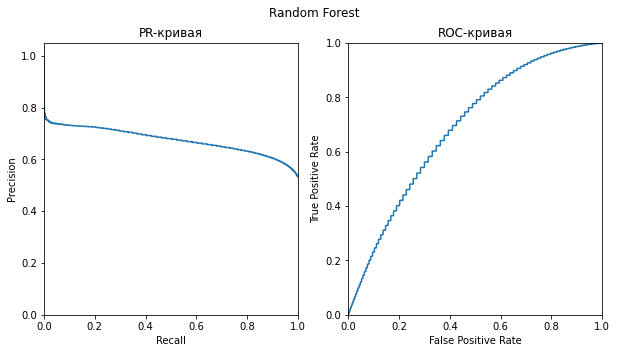

In [ ]:
rf_pipe = evaluate_model(
    clf = RandomForestClassifier(random_state=1, 
                                 class_weight='balanced'),
    train_X=train_X, 
    train_y=train_y, 
    verbose=0, 
    fit_model=True,
    method='predict_proba',
    title='Random Forest'
    )

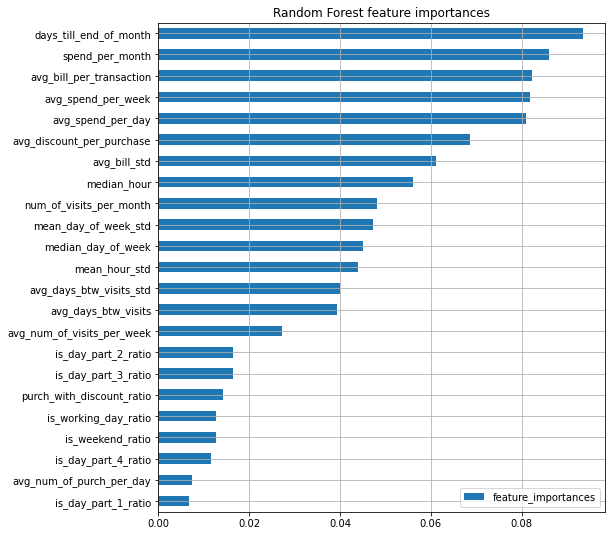

In [ ]:
feature_importance_plot(rf_pipe['estimator'].feature_importances_, 
                        train_X.columns,
                        title='Random Forest feature importances')

### Random Forest with polynomial features

- Random Forest with Polynom -
ROC_AUC_SCORE: 0.6816064085673097
f1_score: 0.661990947060593
precision: 0.6529506748737199 / recall: 0.6712850636359766
accuracy: 0.6342141574126826
Classification report:
              precision    recall  f1-score   support

           0       0.61      0.59      0.60    246415
           1       0.65      0.67      0.66    281916

    accuracy                           0.63    528331
   macro avg       0.63      0.63      0.63    528331
weighted avg       0.63      0.63      0.63    528331

----------------


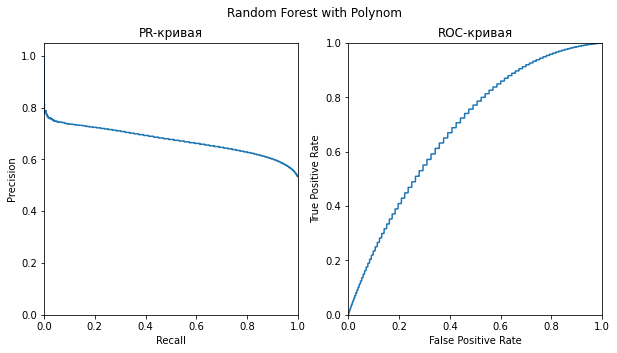

In [ ]:
rf_pipe_plnm = evaluate_model(
    clf = RandomForestClassifier(random_state=1, 
                                 class_weight='balanced'),
    transformer=PolynomialFeatures(degree=2,  
                                   interaction_only=True, 
                                   include_bias=False),
    train_X=train_X, 
    train_y=train_y, 
    verbose=0, 
    fit_model=True,
    method='predict_proba',
    title='Random Forest with Polynom'
    )

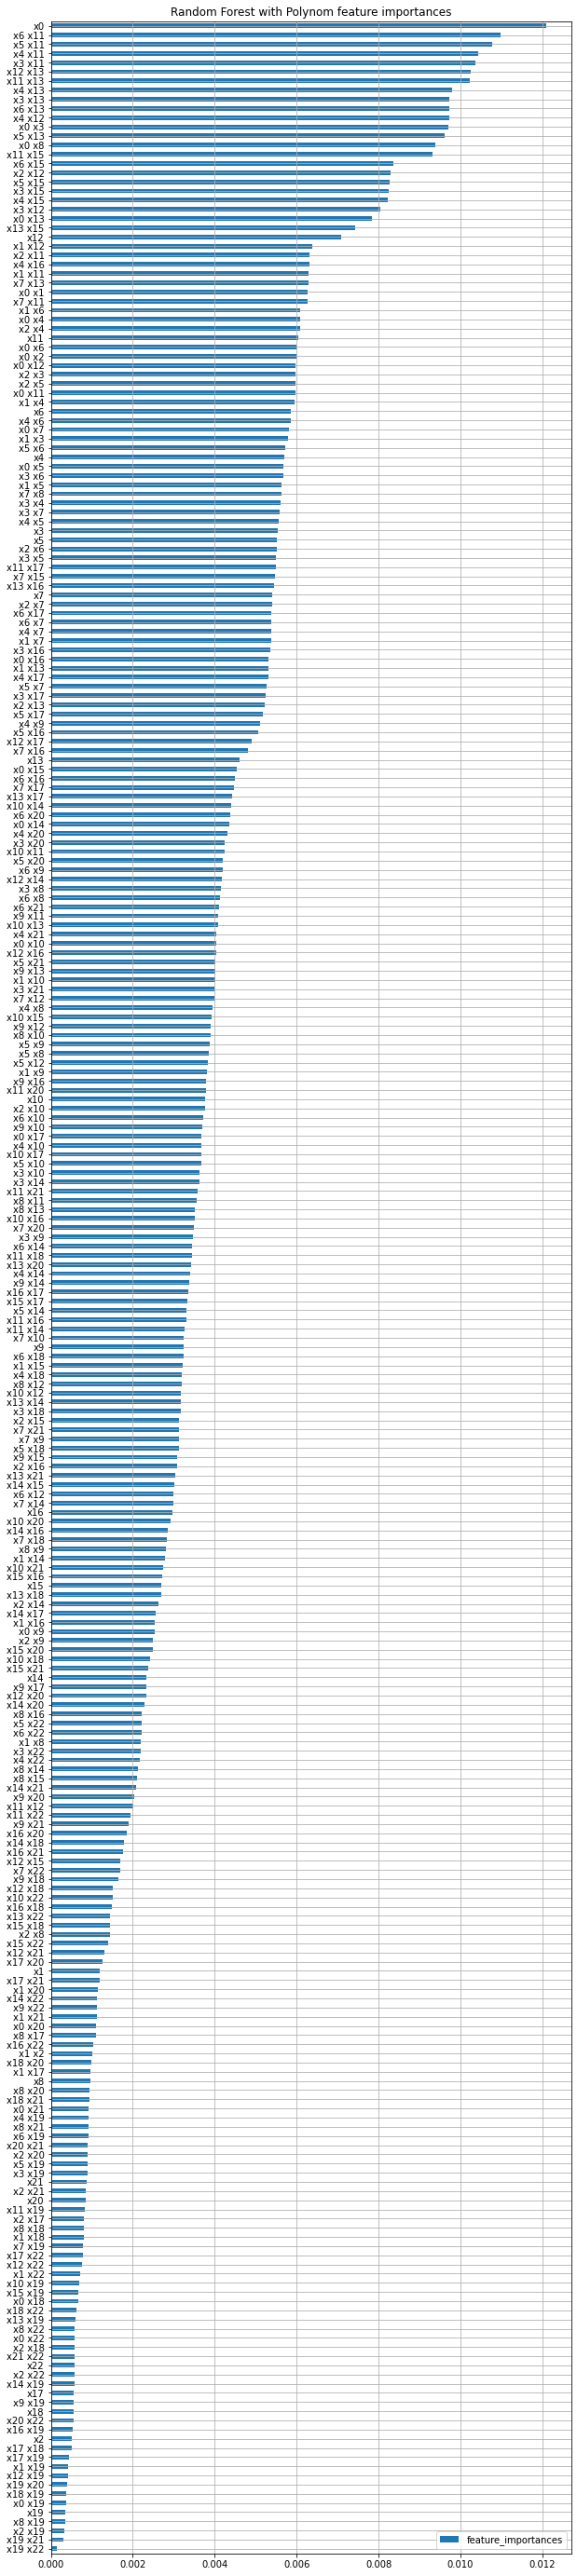

In [ ]:
feature_importance_plot(rf_pipe_plnm['estimator'].feature_importances_, 
                        rf_pipe_plnm['transformer'].get_feature_names_out(),
                        title='Random Forest with Polynom feature importances', 
                        figsize=(10, 50))

## 4.2 K-Nearest Neighbors

- K-Nearest Neighbors Classifier -
ROC_AUC_SCORE: 0.6458292402344301
f1_score: 0.6444103534713026
precision: 0.6356912861466677 / recall: 0.653371926389421
accuracy: 0.6152393102051554
Classification report:
              precision    recall  f1-score   support

           0       0.59      0.57      0.58    246415
           1       0.64      0.65      0.64    281916

    accuracy                           0.62    528331
   macro avg       0.61      0.61      0.61    528331
weighted avg       0.61      0.62      0.61    528331

----------------


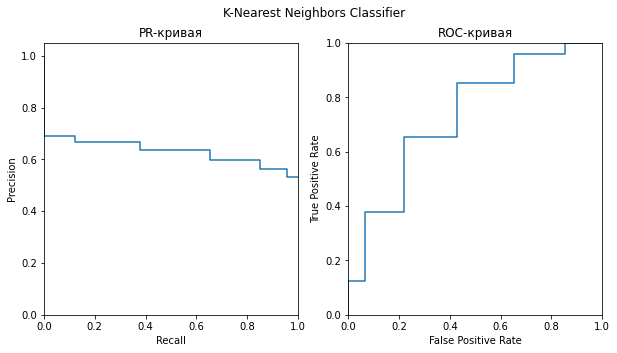

In [ ]:
knn_pipe = evaluate_model(
    clf = KNeighborsClassifier(),
    scaler = StandardScaler(),
    train_X=train_X, 
    train_y=train_y, 
    verbose=0, 
    fit_model=True,
    method='predict_proba',
    title='K-Nearest Neighbors Classifier'
    )

## 4.3 Logistic Regression

### Logistic Regression

- Logistic Regression -
ROC_AUC_SCORE: 0.7221681195622284
f1_score: 0.7017194861400241
precision: 0.6781563935250751 / recall: 0.7269789582712581
accuracy: 0.6702181019095983
Classification report:
              precision    recall  f1-score   support

           0       0.66      0.61      0.63    246415
           1       0.68      0.73      0.70    281916

    accuracy                           0.67    528331
   macro avg       0.67      0.67      0.67    528331
weighted avg       0.67      0.67      0.67    528331

----------------


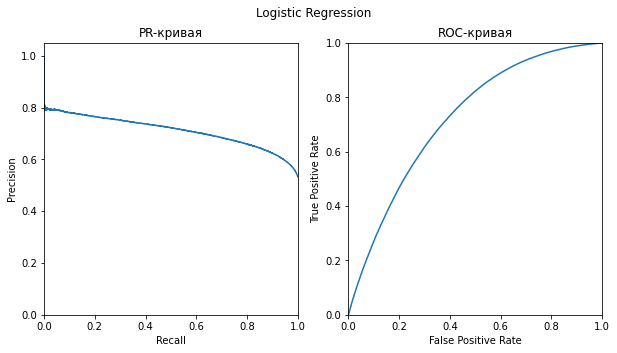

In [ ]:
logreg_pipe = evaluate_model(
    LogisticRegression(class_weight='balanced', 
                       penalty='elasticnet', 
                       l1_ratio=0.5, 
                       solver='saga', 
                       random_state=1), 
    scaler=StandardScaler(), 
    train_X=train_X, 
    train_y=train_y, 
    verbose=0, 
    fit_model=True,
    title='Logistic Regression'
    )

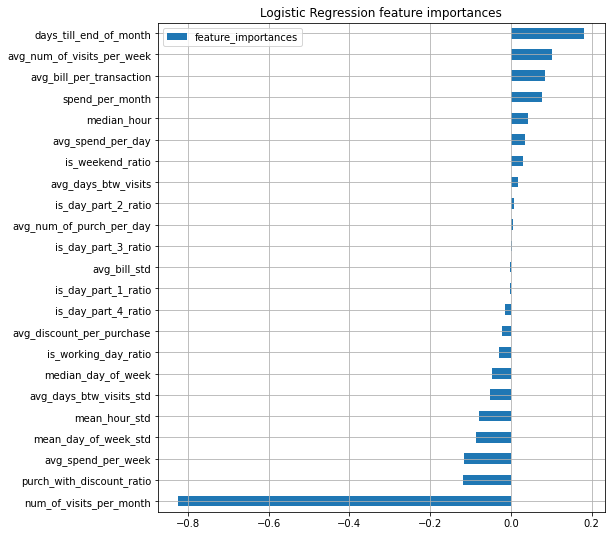

In [ ]:
feature_importance_plot(logreg_pipe['estimator'].coef_.T, 
                        train_X.columns,
                        title='Logistic Regression feature importances')

### Logistic Regression with polynomial features

- Logistic_Regression with Polynom -
ROC_AUC_SCORE: 0.7246471736603173
f1_score: 0.7057670348670004
precision: 0.6782939777637488 / recall: 0.7355595283701528
accuracy: 0.6727411414435269
Classification report:
              precision    recall  f1-score   support

           0       0.67      0.60      0.63    246415
           1       0.68      0.74      0.71    281916

    accuracy                           0.67    528331
   macro avg       0.67      0.67      0.67    528331
weighted avg       0.67      0.67      0.67    528331

----------------


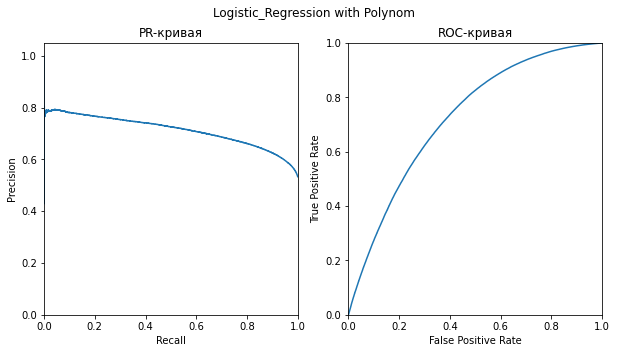

In [ ]:
logreg_pipe_plnm = evaluate_model(
    LogisticRegression(class_weight='balanced', 
                       penalty='elasticnet', 
                       l1_ratio=0.5, 
                       solver='saga', 
                       random_state=1), 
    scaler=StandardScaler(), 
    transformer=PolynomialFeatures(degree=2,  
                                   include_bias=False),
    train_X=train_X, 
    train_y=train_y, 
    verbose=0, 
    fit_model=True,
    title='Logistic_Regression with Polynom'
    )

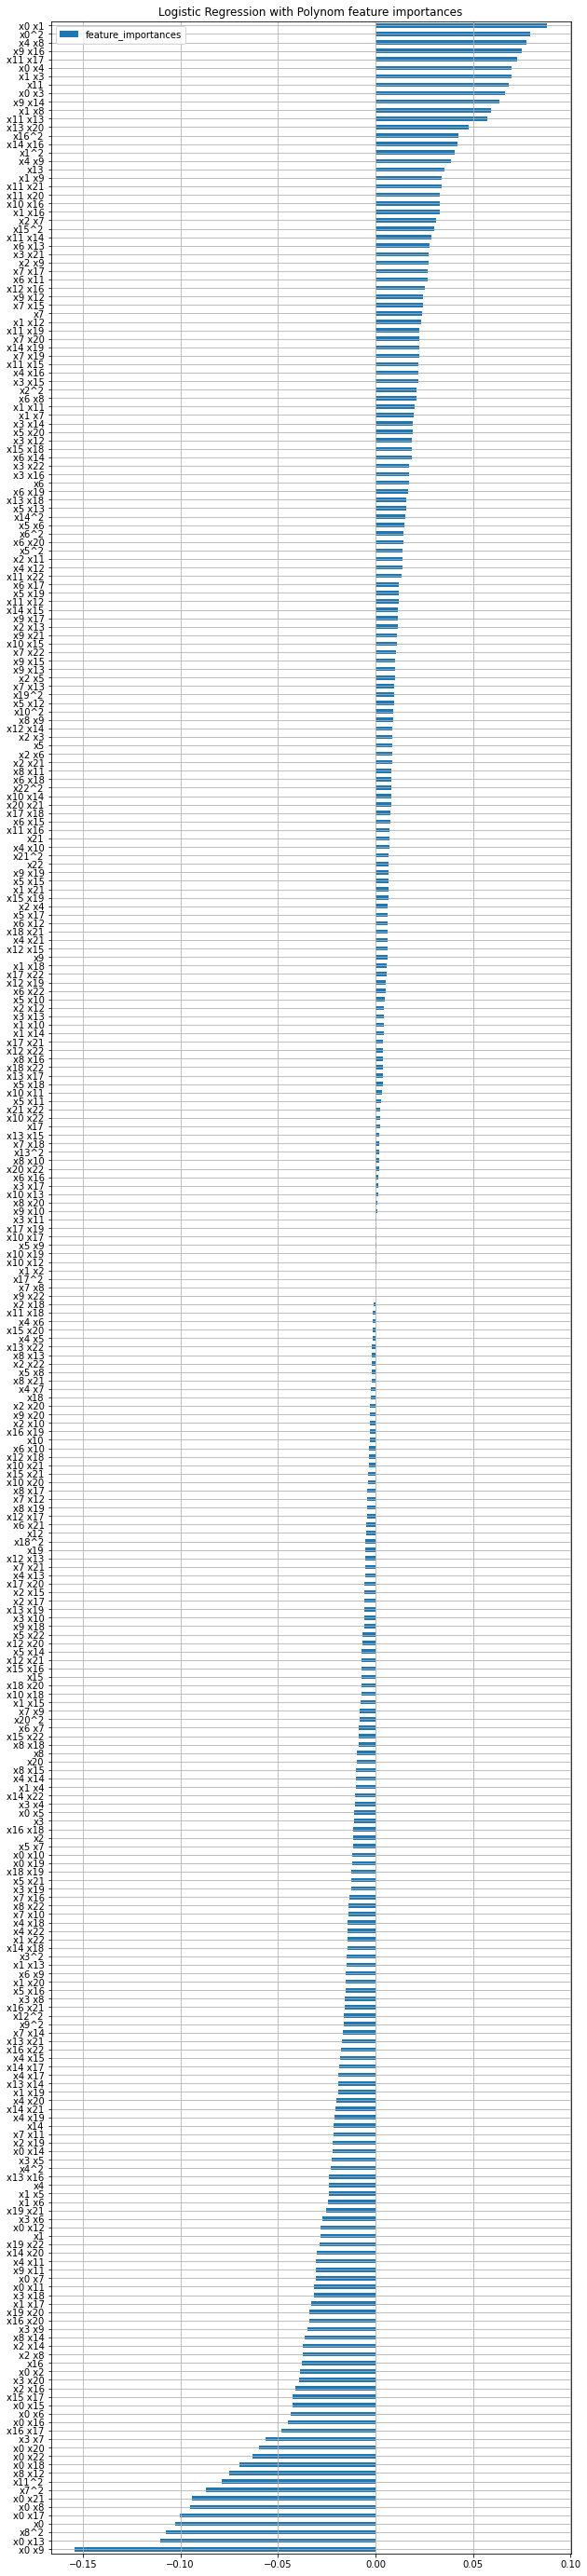

In [ ]:
feature_importance_plot(logreg_pipe_plnm['estimator'].coef_.T, 
                        logreg_pipe_plnm['transformer'].get_feature_names_out(),
                        title='Logistic Regression with Polynom feature importances',
                        figsize=(10, 50))

## 4.4 Support Vector Machine

### Support Vector Machine

- SVM Classifier -
ROC_AUC_SCORE: 0.7110637228775667
f1_score: 0.7112729649910278
precision: 0.6652297563943022 / recall: 0.7641637934703954
accuracy: 0.668959421271892
Classification report:
              precision    recall  f1-score   support

           0       0.67      0.56      0.61    246415
           1       0.67      0.76      0.71    281916

    accuracy                           0.67    528331
   macro avg       0.67      0.66      0.66    528331
weighted avg       0.67      0.67      0.67    528331

----------------


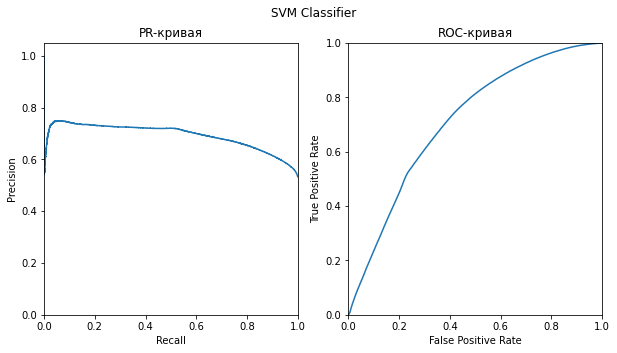

In [ ]:
svm_pipe = evaluate_model(
    clf=SGDClassifier(random_state=1, 
                      early_stopping=True, 
                      n_iter_no_change=100, 
                      class_weight='balanced'),
    scaler=StandardScaler(), 
    train_X=train_X, 
    train_y=train_y, 
    verbose=0, 
    fit_model=True,
    method='decision_function',
    title='SVM Classifier'
    )

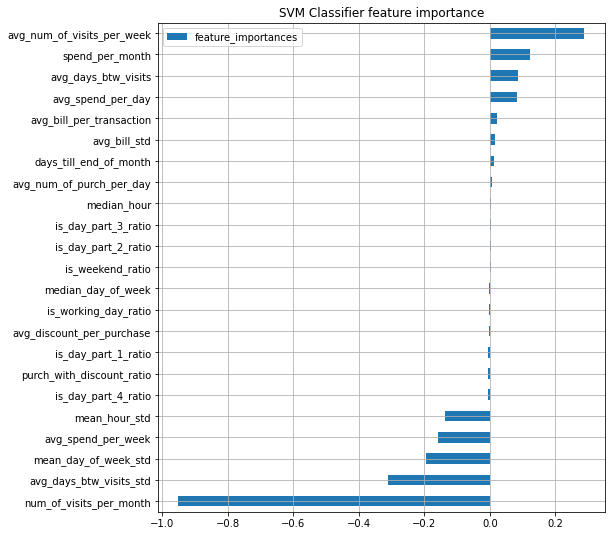

In [ ]:
feature_importance_plot(svm_pipe['estimator'].coef_.T, 
                        train_X.columns,
                        title='SVM Classifier feature importance')

### Support Vector Machine with polynomial features

- SVM Classifier with Polynom -
ROC_AUC_SCORE: 0.7126009452528211
f1_score: 0.7029599555536562
precision: 0.6784388518407307 / recall: 0.7293200811589268
accuracy: 0.6711133740022827
Classification report:
              precision    recall  f1-score   support

           0       0.66      0.60      0.63    246415
           1       0.68      0.73      0.70    281916

    accuracy                           0.67    528331
   macro avg       0.67      0.67      0.67    528331
weighted avg       0.67      0.67      0.67    528331

----------------


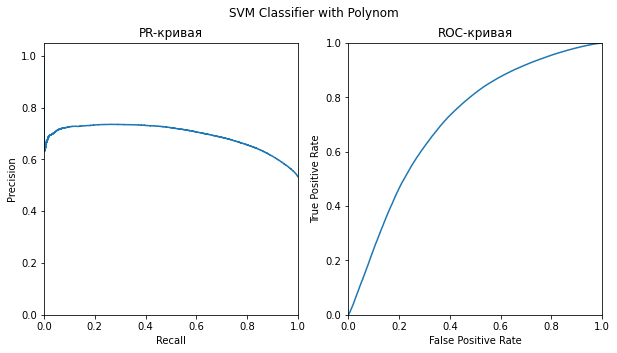

In [ ]:
svm_pipe_polynom = evaluate_model(
    clf=SGDClassifier(random_state=1, 
                      early_stopping=True, 
                      n_iter_no_change=100, 
                      class_weight='balanced'),
    transformer=PolynomialFeatures(degree=2,  
                                   include_bias=False),
    scaler=StandardScaler(), 
    train_X=train_X, 
    train_y=train_y, 
    verbose=0, 
    fit_model=True,
    method='decision_function',
    title='SVM Classifier with Polynom'
    )

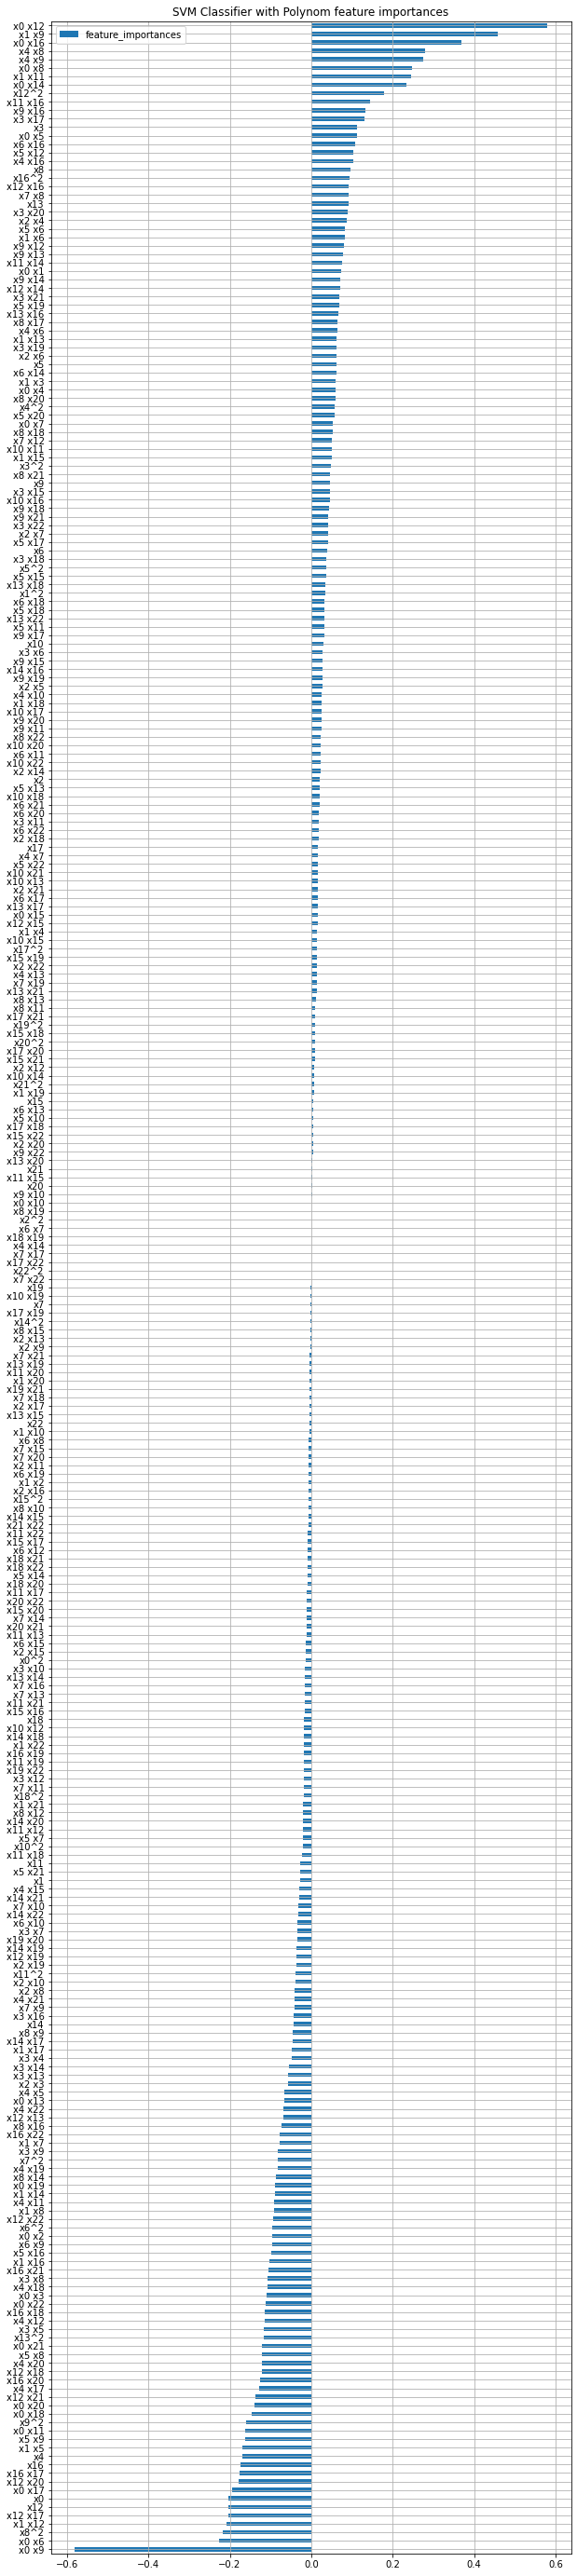

In [ ]:
feature_importance_plot(svm_pipe_polynom['estimator'].coef_.T, 
                        svm_pipe_polynom['transformer'].get_feature_names_out(),
                        title='SVM Classifier with Polynom feature importances',
                        figsize=(10, 50))

## 4.5 Gradient Boosting

### CatBoost (max ROC_AUC)

- CatBoost -
ROC_AUC_SCORE: 0.7125562662681809
f1_score: 0.6852288732703172
precision: 0.677754915805873 / recall: 0.6928695072291037
accuracy: 0.6603322538332976
Classification report:
              precision    recall  f1-score   support

           0       0.64      0.62      0.63    246415
           1       0.68      0.69      0.69    281916

    accuracy                           0.66    528331
   macro avg       0.66      0.66      0.66    528331
weighted avg       0.66      0.66      0.66    528331

----------------


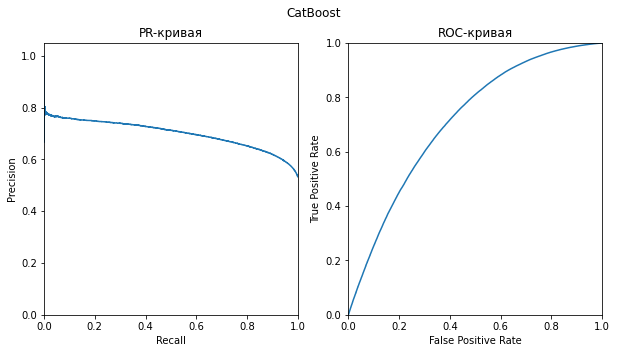

In [ ]:
catboost_pipe = evaluate_model(
    clf = CatBoostClassifier(
        eval_metric='AUC',
        random_seed=1,
        auto_class_weights='Balanced',
        verbose=False), 
    train_X=train_X, 
    train_y=train_y, 
    verbose=0, 
    fit_model=True,
    method='predict_proba',
    title='CatBoost'
    )

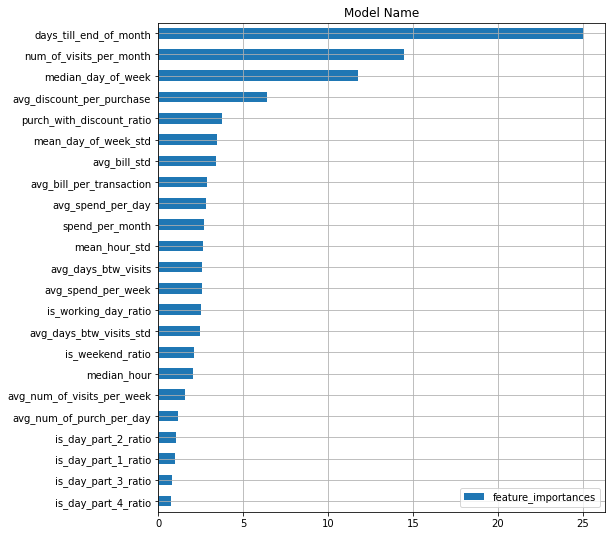

In [ ]:
feature_importance_plot(catboost_pipe['estimator'].feature_importances_, 
                        train_X.columns)

### CatBoost (max F1)

- CatBoost -
ROC_AUC_SCORE: 0.7125562662681809
f1_score: 0.6852288732703172
precision: 0.677754915805873 / recall: 0.6928695072291037
accuracy: 0.6603322538332976
Classification report:
              precision    recall  f1-score   support

           0       0.64      0.62      0.63    246415
           1       0.68      0.69      0.69    281916

    accuracy                           0.66    528331
   macro avg       0.66      0.66      0.66    528331
weighted avg       0.66      0.66      0.66    528331

----------------


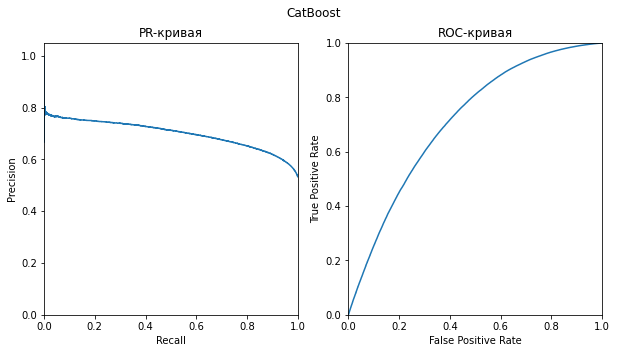

In [ ]:
catboost_pipe = evaluate_model(
    clf = CatBoostClassifier(
        eval_metric='F1',
        random_seed=1,
        auto_class_weights='Balanced',
        verbose=False), 
    train_X=train_X, 
    train_y=train_y, 
    verbose=0, 
    fit_model=True,
    method='predict_proba',
    title='CatBoost'
    )

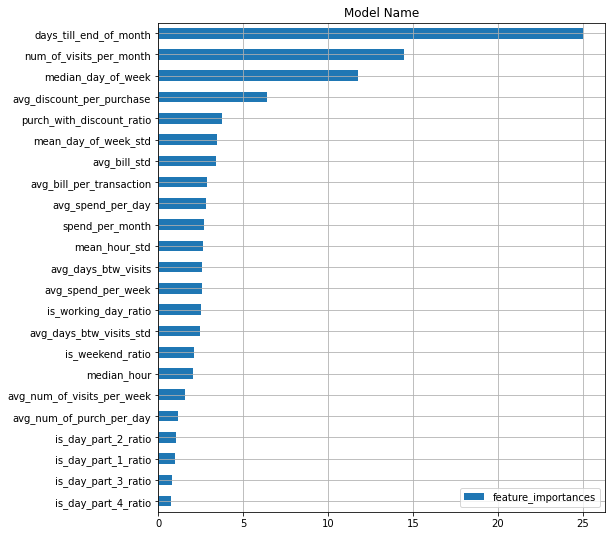

In [ ]:
feature_importance_plot(catboost_pipe['estimator'].feature_importances_, 
                        train_X.columns)

### CatBoost with polynomial features

- CatBoost with Polynom -
ROC_AUC_SCORE: 0.7091735880226588
f1_score: 0.6761352157007305
precision: 0.6756299187498672 / recall: 0.6766412690304914
accuracy: 0.6541145607583125
Classification report:
              precision    recall  f1-score   support

           0       0.63      0.63      0.63    246415
           1       0.68      0.68      0.68    281916

    accuracy                           0.65    528331
   macro avg       0.65      0.65      0.65    528331
weighted avg       0.65      0.65      0.65    528331

----------------


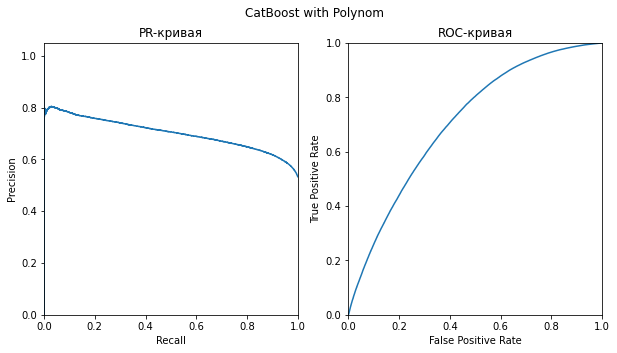

In [ ]:
catboost_pipe_polynom = evaluate_model(
    clf = CatBoostClassifier(
        eval_metric='AUC',
        auto_class_weights='Balanced',
        random_seed=1,
        verbose=False), 
    transformer=PolynomialFeatures(degree=2,  
                                   interaction_only=True, 
                                   include_bias=False),
    train_X=train_X, 
    train_y=train_y, 
    verbose=0, 
    fit_model=True,
    method='predict_proba',
    title='CatBoost with Polynom'
    )

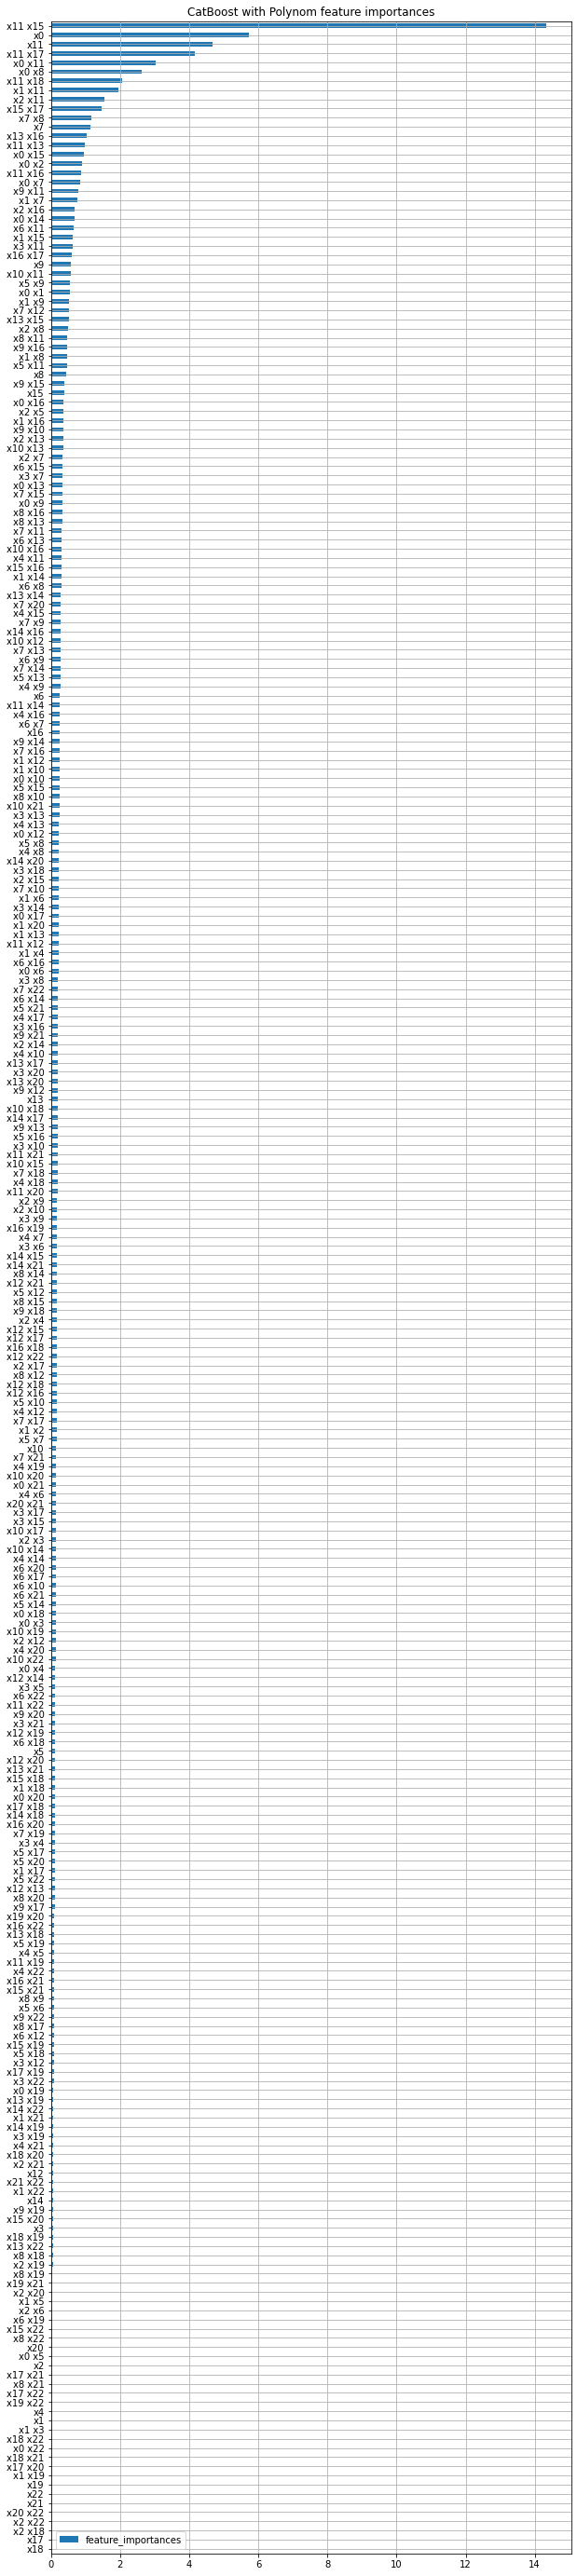

In [ ]:
feature_importance_plot(catboost_pipe_polynom['estimator'].feature_importances_, 
                        catboost_pipe_polynom['transformer'].get_feature_names_out(),
                        title='CatBoost with Polynom feature importances', 
                        figsize=(10, 50))

## Результаты работы базовых моделей

In [ ]:
results_table = pd.DataFrame(
    {
        'Random Forest': [68.5, 66.7, 63.8, 65.5, 68], 
        'Random Forest with Polynom': [68.2, 66.2, 63.4, 65.3, 67.1],
        'KNN': [64.6, 64.4, 61.5, 63.6, 65.3],
        'Logistic Regression': [72.2, 70.2, 67, 67.8, 72.7], 
        'Logistic_Regression with Polynom': [72.5, 70.6, 67.3, 67.8, 73.6], 
        'SVM Classifier': [71.1, 71.1, 66.9, 66.5, 76.4],
        'SVM Classifier with Polynom': [71.3, 70.3, 67.1, 67.8, 72.9],
        'CatBoost (max roc_auc)': [71.3, 68.5, 66, 67.8, 69.3], 
        'CatBoost (max f1)': [71.3, 68.5, 66, 67.8, 69.3],
        'CatBoost with Polynom (max roc_auc)': [70.9, 67.6, 65.4, 67.6, 67.7]
    },
    index=['ROC-AUC', 'F1', 'Accuracy', 'Precision', 'Recall']
)

results_table.T

,ROC-AUC,F1,Accuracy,Precision,Recall
Random Forest,68.5,66.7,63.8,65.5,68.0
Random Forest with Polynom,68.2,66.2,63.4,65.3,67.1
KNN,64.6,64.4,61.5,63.6,65.3
Logistic Regression,72.2,70.2,67.0,67.8,72.7
Logistic_Regression with Polynom,72.5,70.6,67.3,67.8,73.6
SVM Classifier,71.1,71.1,66.9,66.5,76.4
SVM Classifier with Polynom,71.3,70.3,67.1,67.8,72.9
CatBoost (max roc_auc),71.3,68.5,66.0,67.8,69.3
CatBoost (max f1),71.3,68.5,66.0,67.8,69.3
CatBoost with Polynom (max roc_auc),70.9,67.6,65.4,67.6,67.7


Для дальнейшей работы возмем модель `Logistic_Regression`. Данная модель показала реузультат практически равный модели логистической регрессии, обученной на полиномиальных признаках. Однако преимущества простой модели логистической регрессии состоят в том, что во-первых - она интрпретируема, во-вторых гораздо быстрее обучается.

# 5. Оптимизация гиперпараметров и калибровка вероятностей.

## 5.1 Настроим гиперпараметры для выбранной модели.

Для того, чтобы перейти к следующему этапу (калибровке вероятностей), подберем наилучшие гиперпараметры для выбранной модели (`Logistic_Regression`)

In [ ]:
log_reg = LogisticRegression(penalty='elasticnet', solver='saga', random_state=1, class_weight='balanced')
log_reg_pipe = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value=0)),
                         ('scaler', StandardScaler()),
                         ('estimator', log_reg)])

search_space = {
                'estimator__l1_ratio': hp.choice(label='l1_ratio', 
                                              options=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                'estimator__C': hp.choice(label='C', 
                                        options=[0.001, 0.01, 0.1, 1, 10, 100])
                }

def objective(params):
    model = log_reg_pipe.set_params(**params)
    score = cross_val_score(model, train_X, train_y, cv=logo_cv, groups=month_groups, scoring='roc_auc')
    score_final = -1 * score.mean()
    # Возвращаем результаты, которые записываются в Trials()
    return {'loss': score_final, 'params': params, 'status': STATUS_OK}


def run_trials(n):
  for i in range(n):
    trials_step = 3  # how many additional trials to do after loading saved trials. 1 = save after iteration
    max_trials = 1 # initial max_trials. put something small to not have to wait
    
    try:  # try to load an already saved trials object, and increase the max
        trials = pickle.load(open("/content/drive/MyDrive/ds_masterskaya/trials.pkl", "rb"))
        print("Found saved Trials! Loading...")
        max_trials = len(trials.trials) + trials_step
        print("Rerunning from {} trials to {} (+{}) trials".format(len(trials.trials), max_trials, trials_step))
    except:  # create a new trials object and start searching
        trials = Trials()

    rand = max_trials
    best = fmin( 
          # функция для оптимизации  
            fn=objective,
          # пространство поиска гиперпараметров  
            space=search_space,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
            max_evals=max_trials,
          # куда сохранять историю поиска
            trials=trials,
          # random state
            rstate=np.random.RandomState(rand),
          # progressbar
            show_progressbar=True
        )

    print("Best:", best)
    print(trials.results[np.argmin([r['loss'] for r in trials.results])]['params'])
    
    # save the trials object
    with open('/content/drive/MyDrive/ds_masterskaya/trials.pkl', "wb") as f:
        pickle.dump(trials, f)

In [ ]:
# Запустим процесс подбора гиперпараметров 4 раза.
run_trials(15)

Found saved Trials! Loading...
Rerunning from 13 trials to 16 (+3) trials
100%|██████████| 3/3 [03:17<00:00, 65.99s/it, best loss: -0.729708915504268]
Best: {'C': 1, 'l1_ratio': 8}
{'estimator__C': 0.01, 'estimator__l1_ratio': 0.9}
Found saved Trials! Loading...
Rerunning from 16 trials to 19 (+3) trials
100%|██████████| 3/3 [03:41<00:00, 73.82s/it, best loss: -0.729708915504268]
Best: {'C': 1, 'l1_ratio': 8}
{'estimator__C': 0.01, 'estimator__l1_ratio': 0.9}
Found saved Trials! Loading...
Rerunning from 19 trials to 22 (+3) trials
100%|██████████| 3/3 [03:17<00:00, 65.98s/it, best loss: -0.729708915504268]
Best: {'C': 1, 'l1_ratio': 8}
{'estimator__C': 0.01, 'estimator__l1_ratio': 0.9}
Found saved Trials! Loading...
Rerunning from 22 trials to 25 (+3) trials
100%|██████████| 3/3 [02:53<00:00, 57.97s/it, best loss: -0.7299298381794714]
Best: {'C': 0, 'l1_ratio': 8}
{'estimator__C': 0.001, 'estimator__l1_ratio': 0.9}
Found saved Trials! Loading...
Rerunning from 25 trials to 28 (+3) tri

In [ ]:
# [trials.results[i]['params'] for i in range(len(trials.results))]

In [ ]:
# sorted([trials.results[i]['params'] for i in range(len(trials.results))], key=lambda x: (x['estimator__C'], x['estimator__l1_ratio']))

In [ ]:
# Загрузим объект Trials() и сохраним в переменную "trials"
trials = pickle.load(open("/content/drive/MyDrive/ds_masterskaya/trials.pkl", "rb"))

# Сохраним наилучшие гиперпараметры модели в переменную "best_params"
best_params_log_reg_pipe = trials.results[np.argmin([r['loss'] for r in trials.results])]['params']

# Сохраним переменную "best_params" в файл.
with open('/content/drive/MyDrive/ds_masterskaya/best_params_log_reg_pipe.pkl', "wb") as f:
    pickle.dump(best_params_log_reg_pipe, f)

# Выведем на экран лучшие гиперпараметры модели
print(best_params_log_reg_pipe)

{'estimator__C': 0.001, 'estimator__l1_ratio': 0.9}


Оценим результаты модели с подобранными гиперпараметрами.

- Logistic_Regression Tuned -
ROC_AUC_SCORE: 0.722221512747859
f1_score: 0.7011897006891349
precision: 0.678499389564202 / recall: 0.7254501340824927
accuracy: 0.6700780381995378
Classification report:
              precision    recall  f1-score   support

           0       0.66      0.61      0.63    246415
           1       0.68      0.73      0.70    281916

    accuracy                           0.67    528331
   macro avg       0.67      0.67      0.67    528331
weighted avg       0.67      0.67      0.67    528331

----------------


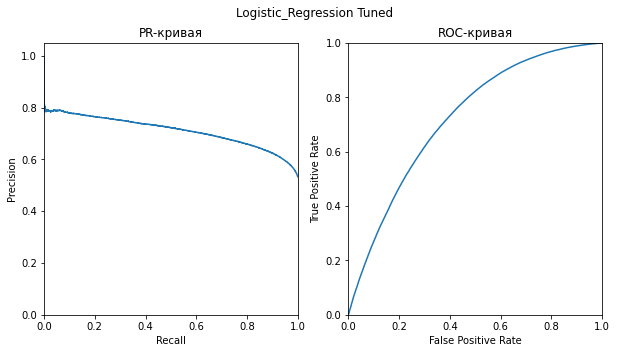

In [ ]:
# Загрузим подобранные гиперпараметры для пайплайна в переменную "best_params_log_reg_pipe"
best_params_log_reg_pipe = pickle.load(open("/content/drive/MyDrive/ds_masterskaya/best_params_log_reg_pipe.pkl", "rb"))

# Произведем оценку модели с подобранными гиперпараметрами
log_reg_pipe_best = evaluate_model(
    LogisticRegression(class_weight='balanced', 
                       penalty='elasticnet', 
                      #  C=0.001 ,
                      #  l1_ratio=0.9, 
                       solver='saga', 
                       random_state=1), 
    scaler=StandardScaler(),
    train_X=train_X, 
    train_y=train_y, 
    verbose=0, 
    fit_model=True,
    title='Logistic_Regression Tuned',
    kw_params=best_params_log_reg_pipe
    )

Результат модели с настроенными гиперпараметрами практически идентичен результату работы модели с настройками, которые мы использовали по умолчанию (`l1_ratio` = 0.5, `C`=1)

In [ ]:
# Сохраним гиперпараметры логистической регрессии в переменную "best_params_log_reg"
best_params_log_reg = log_reg_pipe_best['estimator'].get_params()

with open('/content/drive/MyDrive/ds_masterskaya/best_params_log_reg.pkl', "wb") as f:
    pickle.dump(best_params_log_reg, f)

#### Резюме


На данном этапе мы подобрали гиперпараметры для модели логистической регрессии.  
Наилучшие гипрепараметры: `C`=0.001, `l1_ratio`=0.9

## 5.2 Калибровка вероятностей

На данном этапе оценим посмотрим на вероятностную кривую классификатора, а также произведем калибровку.

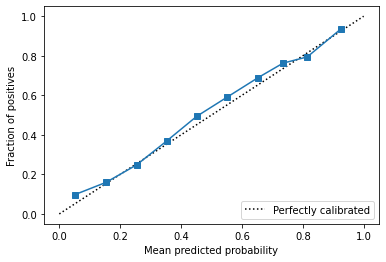

In [ ]:
final_clf = Pipeline([
                 ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
                 ('scaler', StandardScaler()),
                 ('estimator', LogisticRegression(class_weight='balanced', 
                                                  penalty='elasticnet', 
                                                  C=0.001,
                                                  l1_ratio=0.9, 
                                                  solver='saga', 
                                                  random_state=1))
    ]
)

y_prob = cross_val_predict(final_clf, train_X, train_y, cv=logo_cv, groups=month_groups, method='predict_proba')[:, 1]
prob_true, prob_pred = calibration_curve(train_y, y_prob, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, y_prob)
disp.plot()

В целом, классификатор выдает хорошие вероятности, однако когда доля положительных объектов достигает 0.9 - классификатор резко выдает заниженные вероятности.

Осуществим калибровку вероятностей. Откалиброванный классификатор сохраним в переменную `calibrated_final_clf`

In [ ]:
calibrated_final_clf = CalibratedClassifierGroupCV(base_estimator=final_clf, cv=logo_cv)
calibrated_final_clf.fit(train_X, train_y, groups=month_groups)

CalibratedClassifierGroupCV(base_estimator=Pipeline(steps=[('imputer',
                                                            SimpleImputer(fill_value=0,
                                                                          strategy='constant')),
                                                           ('scaler',
                                                            StandardScaler()),
                                                           ('estimator',
                                                            LogisticRegression(C=0.001,
                                                                               class_weight='balanced',
                                                                               l1_ratio=0.9,
                                                                               penalty='elasticnet',
                                                                               random_state=1,
                                         

# Финальная проверка.

Проверим на тестовых данных 2 модели:  
- Логистическую регрессию, обученную на полиномиальных признаках
- Ту же модель, но с откалиброванными вероятностями

В тренировочном датасете классы более-менее сбалансировованы. А вот в тестовом наборе данных у нас уже очень сильный дисбаланс.   

In [ ]:
# # Инициализируем модели
# final_clf = Pipeline([
#                  ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
#                  ('scaler', StandardScaler()),
#                  ('estimator', LogisticRegression(class_weight='balanced', 
#                                                   penalty='elasticnet', 
#                                                   C=0.001,
#                                                   l1_ratio=0.9, 
#                                                   solver='saga', 
#                                                   random_state=1))
#     ]
# )

# calibrated_final_clf = CalibratedClassifierGroupCV(
#     base_estimator=final_clf, 
#     cv=logo_cv
# )

# # Обучим модели на всей обучающей выборке
# final_clf.fit(train_X, train_y)
# calibrated_final_clf.fit(train_X, train_y, groups=month_groups)

# # Сохраним обученные модели для быстрого доступа к ним
# with open('/content/drive/MyDrive/ds_masterskaya/final_clf.pkl', "wb") as f:
#         pickle.dump(final_clf, f)
# with open('/content/drive/MyDrive/ds_masterskaya/calibrated_final_clf.pkl', "wb") as f:
#         pickle.dump(calibrated_final_clf, f)

In [ ]:
# # Загрузим классификаторы и сохраним их в переменные
final_clf = pickle.load(open("/content/drive/MyDrive/ds_masterskaya/final_clf.pkl", "rb"))
calibrated_final_clf = pickle.load(open("/content/drive/MyDrive/ds_masterskaya/calibrated_final_clf.pkl", "rb"))

# Сохраним предсказания на отложенной выборке в переменные 'pred_proba_test' и 'calibrated_pred_proba_test'
pred_proba_test = final_clf.predict_proba(test_X)[:, 1]
calibrated_pred_proba_test = calibrated_final_clf.predict_proba(test_X)[:, 1]

Оценим обобщаю способность модели `final_clf` на тестовых данных.

- Logistic Regression -
ROC_AUC_SCORE: 0.8258093990415231
f1_score: 0.21504555125197752
precision: 0.12233877475017069 / recall: 0.8878378378378379
accuracy: 0.6053050252359008
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.59      0.74     34236
           1       0.12      0.89      0.22      2220

    accuracy                           0.61     36456
   macro avg       0.56      0.74      0.48     36456
weighted avg       0.94      0.61      0.70     36456

----------------


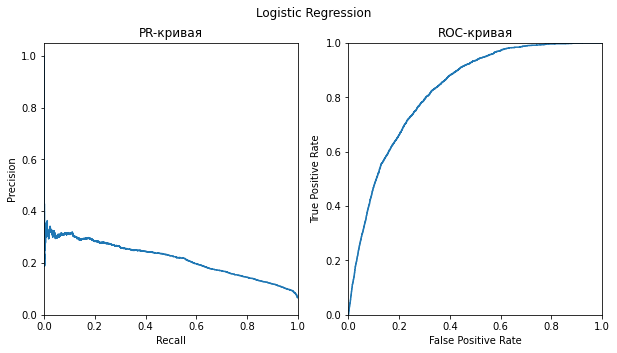

In [ ]:
print_clf_metrics(test_y, pred_proba_test, 'Logistic Regression')
show_curves(y=test_y, predicted_probas=pred_proba_test, suptitle='Logistic Regression');

Оценим обобщаю способность модели `calibrated_final_clf` на тестовых данных.

- Logistic Regression (calibrated) -
ROC_AUC_SCORE: 0.8257525072391002
f1_score: 0.22350539515893844
precision: 0.1283752093802345 / recall: 0.863063063063063
accuracy: 0.63482005705508
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.62      0.76     34236
           1       0.13      0.86      0.22      2220

    accuracy                           0.63     36456
   macro avg       0.56      0.74      0.49     36456
weighted avg       0.93      0.63      0.73     36456

----------------


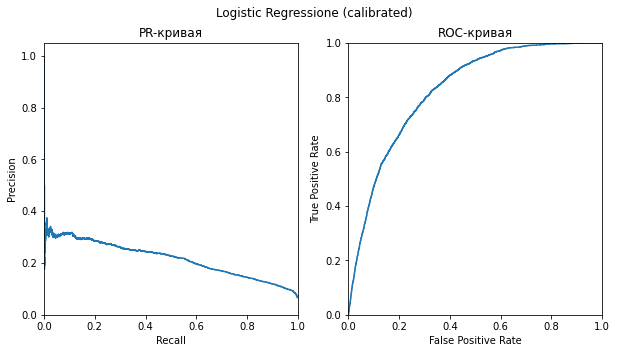

In [ ]:
print_clf_metrics(test_y, calibrated_pred_proba_test, 'Logistic Regression (calibrated)')
show_curves(y=test_y, predicted_probas=calibrated_pred_proba_test, suptitle='Logistic Regressione (calibrated)');

Посмотрим, какие результаты даст dummy-модель на тестовых данных.

In [ ]:
dummy_clf = DummyClassifier(strategy='uniform', random_state=1)
dummy_clf.fit(train_X, train_y)

predictions_dummy = dummy_clf.predict(test_X)
print_clf_metrics(test_y, predictions_dummy, 'Dummy Classifier')

- Dummy Classifier -
ROC_AUC_SCORE: 0.4978830565581354
f1_score: 0.1077253638050591
precision: 0.060411874246905466 / recall: 0.4968468468468468
accuracy: 0.49879306561334213
Classification report:
              precision    recall  f1-score   support

           0       0.94      0.50      0.65     34236
           1       0.06      0.50      0.11      2220

    accuracy                           0.50     36456
   macro avg       0.50      0.50      0.38     36456
weighted avg       0.89      0.50      0.62     36456

----------------


Выведем результаты на экран:

In [ ]:
test_results_table = pd.DataFrame(
    {   
        'Logistic_Regression': [82.6, 21.5, 60.5, 12.2, 88.8], 
        'Logistic_Regression calibrated': [82.6, 22.4, 63.5, 12.8, 86.3],
        'Dummy-estimator': [49.8, 10.8, 49.9, 6, 49.7],
    },
    index=['ROC-AUC', 'F1', 'Accuracy', 'Precision', 'Recall']
)

test_results_table.T

,ROC-AUC,F1,Accuracy,Precision,Recall
Logistic_Regression,82.6,21.5,60.5,12.2,88.8
Logistic_Regression calibrated,82.6,22.4,63.5,12.8,86.3
Dummy-estimator,49.8,10.8,49.9,6.0,49.7


ROC-AUC нашего классификатора на тестовой выборке составил 82.6% (против 50 у дамми-модели). F1_SCORE в два раза выше, чем у дамми: 22.4% против 10.8%. ACCURACY составил 63.5% против 49.9% дамми-модели.

Посмотрим на матрицу ошибок.

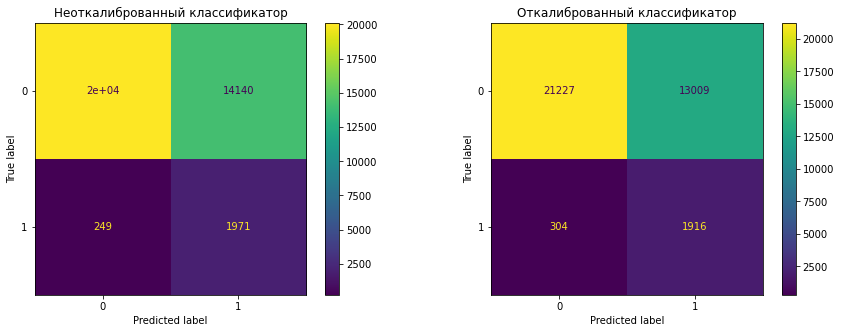

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title('Неoткалиброванный классификатор');
ax[1].set_title('Откалиброванный классификатор');

for i, pred in zip([0, 1], [pred_proba_test, calibrated_pred_proba_test]):
  cm = confusion_matrix(test_y, pred>0.5, labels=[0, 1])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=[0, 1])
  disp.plot(ax=ax[i]);

Можем также посмотреть на распределение вероятностей, которое выдает наш классификатор.

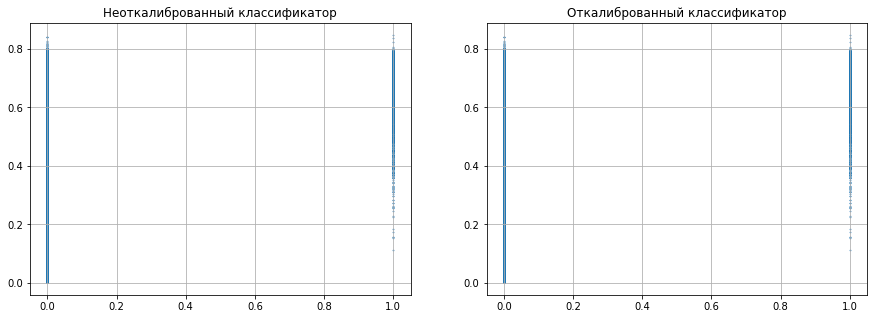

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].scatter(test_y, pred_proba_test, 0.5);
ax[0].grid();
ax[0].set_title('Неоткалиброванный классификатор');

ax[1].scatter(test_y, pred_proba_test, 0.5);
ax[1].grid();
ax[1].set_title('Откалиброванный классификатор');

Посмотрим на важность признаков в модели.

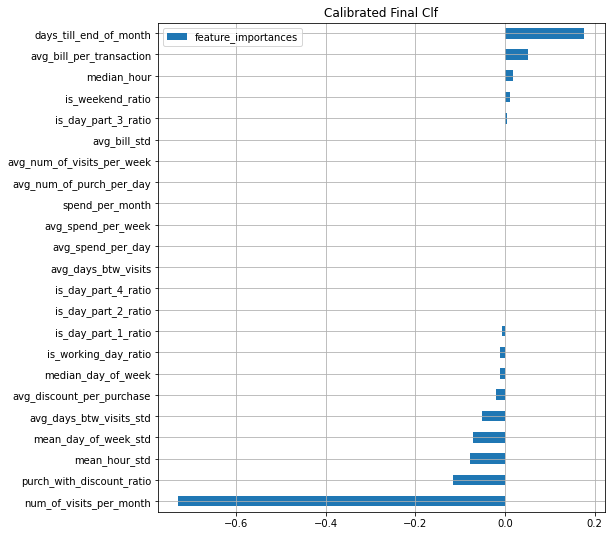

In [ ]:
feature_importance_plot(calibrated_final_clf.base_estimator['estimator'].coef_.T, 
                        test_X.columns,
                        title='Calibrated Final Clf')

Хорошо видно, что наш классификатор слишком сильно ошибается на нулевых объектах. То есть он допускает высокое количество FP ошибок, ошибочно завышая вероятность на объектах нулевого класса. При этом, откалиброванный классификатор допускает меньшее количество FP ошибок.

# Заключение

Целью данной работы было научиться предсказывать пользователей, которые уйдут в отток. В рамках бизнес задачи было принято следующее условие: нас будут интересовать лишь клиенты, которые посетили кофейню более 1-го раза. Соотвественно предсказания мы будем строить только для таких гостей.  
В качестве данных для обучения и тестирования модели были взяты данные за период с января по октябрь включительно. Причина тому в сильном дисбалансе классов, который появляетя в ноябре и декабре

В ходе работы были предприняты следующие шаги:  
- В исходный датасет были добавлены новые признаки, на основе уже имеющихся.
- На основе исходного датасета были созданы еще 2: с агрегацией по клиентам, и с агрегацией по месяцам и клиентам.
- Был произведен исследовательский анализ данных
- Были сгенерированы новые признаки для дальнейшего обучения моделей машинного обучения
- Была произведена проверка работы моделей с настройками по умолчанию. Были получены следующие результаты:    

|                                     |   ROC-AUC |   F1 |   Accuracy |   Precision |   Recall |
|:------------------------------------|----------:|-----:|-----------:|------------:|---------:|
| Random Forest                       |      68.5 | 66.7 |       63.8 |        65.5 |     68   |
| Random Forest with Polynom          |      68.2 | 66.2 |       63.4 |        65.3 |     67.1 |
| KNN                                 |      64.6 | 64.4 |       61.5 |        63.6 |     65.3 |
| Logistic Regression                 |      72.2 | 70.2 |       67   |        67.8 |     72.7 |
| Logistic_Regression with Polynom    |      72.5 | 70.6 |       67.3 |        67.8 |     73.6 |
| SVM Classifier                      |      71.1 | 71.1 |       66.9 |        66.5 |     76.4 |
| SVM Classifier with Polynom         |      71.3 | 70.3 |       67.1 |        67.8 |     72.9 |
| CatBoost (max roc_auc)              |      71.3 | 68.5 |       66   |        67.8 |     69.3 |
| CatBoost (max f1)                   |      71.3 | 68.5 |       66   |        67.8 |     69.3 |
| CatBoost with Polynom (max roc_auc) |      70.9 | 67.6 |       65.4 |        67.6 |     67.7 |

Для дальнейшей работы была выбрана модель логистической регрессии.  
- После был осуществлен подбор гиперпараметров для выбранной модели. Наиболее оптимальными гиперпараметрами оказались С=0.001, l1_ratio=0.9. Результаты модели на кросс-валидации не сильно отличались от гиперпараметров, использованных по умолчанию (С=1, l1_ratio=0.5).
- Следующим шагом была произведена проверка 2-х моделей на отложенной выборке. Проверялись логистическая регрессия и та же модель, но с откалиброванными вероятностями. Откалиброванная модель показала незначительно более высокий результат. 

Результаты моделей представлены ниже:   

|                                |   ROC-AUC |   F1 |   Accuracy |   Precision |   Recall |
|:-------------------------------|----------:|-----:|-----------:|------------:|---------:|
| Logistic_Regression            |      82.6 | 21.5 |       60.5 |        12.2 |     88.8 |
| Logistic_Regression calibrated |      82.6 | 22.4 |       63.5 |        12.8 |     86.3 |
| Dummy-estimator                |      49.8 | 10.8 |       49.9 |         6   |     49.7 |

С одной стороны, есть причины предполагать, что наша модель плохо выявила закономерности в данных. Однако на кросс-валидации показатель F1 был близок к 70%, и точность моделей в два раза выше нежели у константного алгоритма. Более того, тот факт, что с приближением к концу года баланс классов в данных так сильно меняется заставляет задаться вопросом, действительно ли все данные были выгружены и размечены корректно, нет ли каких-то аномалий, и в чем вообще может быть причина такого дисбаланса.   
  
Одной из причин, почему поведение "не-отточных" гостей для модели становится похожим на поведение "отточных" также может быть тот факт, что 2020 год - это год, когда действовали ковидные ограничения на общепит. Это могло отразиться на частоте посещение кафе даже со стороны "не-отточных" клиентов (следует принять во внимание, что одни из наиболее важных признаков у нас связаны как раз таки с количеством посещений в месяц, а также с количеством дней, которое прошло от последнего посещения клиента до 31 числа месяца).  
Возможно, отчасти поэтому на данных за октябрь модель показала такой результат.  

Интепретация модели:  

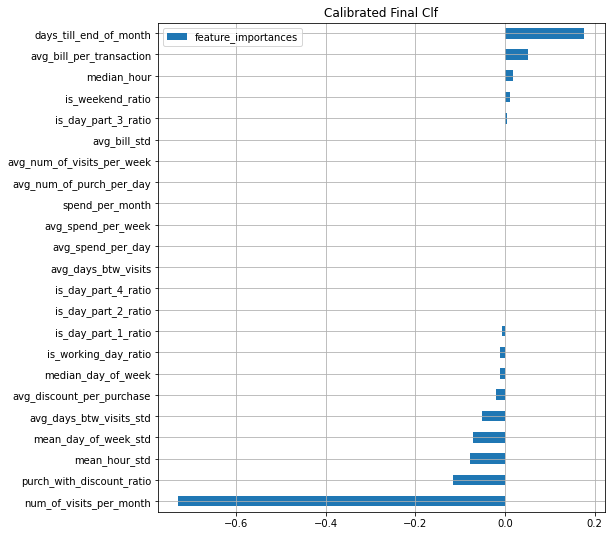





Из графика видно, что чем больше "дней от последнего посещения гостя до конца месяца", а также чем меньше "посещений в течение месяца" совершил клиент, тем выше вероятность того, что он уйдет в отток. При этом, наиболее весомым признаком является "количество посещений за месяц".

